# Community Water System Prediction Model

**Overview**  
The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season.

We develop a machine learning model that predicts which CWS face the highest risk of running out of water. The model architecture is a Support Vector Machine, from the open source scientific software package [scikit-learn](https://scikit-learn.org/stable/). The model is intended to run in production on an annual basis, during April of every year.

The dataset used to train and test the model comprises of 5772 examples that describe 2886 CWS over a span of two years, from 2021 to 2023. We use 15 features and one outcome label to describe each example. The outcome label itself is a composite, consisting of three separate conditions that a CWS may experience: reliance on bottled or hauled water, receipt of a drought violation, or contention of a curtailment. We define a CWS that experiences any one, or multiple, of these conditions, as `DroughtExperienced`. We define a CWS that experiences none of these conditions as not `DroughtExperienced.`

**Features**  
The features in the dataset span various time scales -- some vary annually, others vary seasonally, and some remain static over time. The following table describes each feature and its associated timescale.

Feature | Description | Timescale
---|---|---
`DSCI Dry Season Average`| The [US Drought Monitor Data](https://droughtmonitor.unl.edu/) database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). This feature takes the average value of the DSCI during the dry season, which spans from May 1 to September 30 in any given calendar year. | Seasonal (October 1 - April 1)
`DSCI Wet Season Average`| This feature takes the average value of the DSCI during the wet season, which spans from October 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - September 30)
`DSCI Dry Wet Delta`| This feature takes the difference of the average value of the DSCI during the dry season and wet season. The data that goes into this calculation spans 11 months, from May 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - April 1)
`Total Number of Water Sources`| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 74): "Total number of available water sources including surface water, wells, and imported/purchased water." | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Intertie`| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 76): "An intertie or interconnection is a connection between one or more water systems where systems can either supply or receive water from each other. The presence of interties is assumed to reduce the risk of a water outage by allowing water systems to switch sources and even governance structure support, if needed." If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Score_CriticallyOverdraftedGroundwaterBasin`| This indicates whether the CWS is located within a critically overdrafted groundwater basin. According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 80): "A basin is subject to critical conditions of overdraft when continuation of current water management practices would probably result in significant adverse overdraft-related environmental, social, or economic impacts." Per table A30, this value equals 0 if fewer than 25% of system’s wells reside in such a basin and 1 otherwise. | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Score_SCV`| According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 82): "The purpose of this risk indicator is to identify water systems that have violated source capacity standards as required in California Waterworks Standards82 within the last three years." If this is true, the value of Score_SCV equals 1. Otherwise it is 0. | Annual. We assume this variable describes three years of data, from January 1 of the first year to December 31 of the third year. These data may be available quarterly via SAFER.
`Score_SCM`| This risk indicator identifies whether a water system experienced a service connection moratorium within the last three years. | Annual. This feature describes the last three years of behavior.
`Curtailment`| Whether the CWS experienced a curtailment within the calendar year. | Annual
`ServiceConnections`| The number of service connections to a CWS. | Annual
`PWPhysicalAddressLat`| The latitude of the CWS. | Static
`PWPhysicalAddressLong`| The longitude of the CWS. | Static
`HUC_Categories`| Whether the CWS is located in a coastal region (1), the central valley (2), or some other region (3). | Static
`Population`| The population served by a given CWS. | Static
`Wholesalers`| Whether (1) or not (0) the CWS is a wholesaler. These CWS do not serve anybody directly, but serve other CWS -- which in turn, serve people directly. | Static

**Label**  
The labels in the dataset span various time scales. The following table describes each label and its associated timescale.

Label | Description | Timescale
---|---|---
`WaterOutageDroughtViolation`| Describes wether (1) or not (0) the system experienced a water outage violation in the last year. | Annual
`BottledHauledWaterOrZeroSource`| According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf): "The purpose of this risk indicator is to identify water systems that have had to supplement or replace their source of supply to meet customer demand with bottled water, and/or hauled water at any point within the past three years." | We use this annually, but it is available quarterly via SAFER. This feature describes the last three years of behavior.
`CurtailmentExemptionPetition`|  Describes wether (1) or not (0) the system petitioned a curtailment in the last year.| Annual
`DroughtExperienced`|  Describes wether (1) or not (0) the system petitioned a curtailment in the last year.| Annual


**Resources**  
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

Import some packages.

To use water.ipynb notebooks together with all the requisite Python packages, create a new conda environment called water using the provided environment file by running this command: 
```python
conda env create -f environment.yml
```

In [1]:
import itertools
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime as dt_obj
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from IPython.display import display
 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)

### Create 2021 Data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`.

In [2]:
def get_data_from_local_directory(filename, path):
    """
        Get data from a local directory.

        Parameters
        ----------
        filename : str
            Name of file to get from local directory.
        path : str
            Path to local directory.
        
        Returns
        -------
        df : pandas.DataFrame
            Dataframe containing data from local directory.
        
        Examples
        --------
        >>> get_data_from_local_directory('test.csv', 'data/')
    """
    file_with_path = path + filename
    df = pd.read_csv(file_with_path)
    
    return df

Read in the initial data sets:

In [3]:
df1 = get_data_from_local_directory(filename='DroughtWatchPrioritization_v4.csv', path='data/')
df2 = get_data_from_local_directory(filename='DroughtWatchPrioritization_v9_input_data_with_TNC.csv', path='data/')

The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [4]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [5]:
df_2021_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [6]:
df_2021_initial['HUC8'] = df_2021_initial['HUC8'].str.replace("-", "").astype(int)

Add a column called `Water Year` and set the the values to 2021:

In [7]:
df_2021_initial['Water Year'] = 2021

#### A. Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Note: As of Monday, July 17 2023, the USDM Rest API is down. I have downloaded all the relevant data from the [comprehensive statistics](https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx) page into a file called `DSCI.csv` for temporary use. 

* Select all HUC8 codes that start with 15, 16, 17, and 18.
* Select Statistics Type = Categorical.

Complete Step 1:

In [8]:
# Read in the simplified mapping of HUC8 codes within the stae of California from the California Open Data Portal
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
df_huc8 = pd.read_csv(url_huc8)

In [9]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2022-05-01'), dt_obj.fromisoformat('2021-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2022-09-30'), dt_obj.fromisoformat('2021-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2022-10-01'), dt_obj.fromisoformat('2021-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2023-04-01'), dt_obj.fromisoformat('2022-04-01')]

Complete Steps 2 and 3:

In [10]:
def compute_dsci_per_season(filename, path):
    """
    This function computes the average DSCI per season for each HUC8 region in California.

    Parameters
    ----------
    filename : str
        The name of the file to be read.
    path : str
        Path to local directory.

    Returns
    -------
    all_average_dscis_dry_season : list
        A list of lists containing the average DSCI per dry season for each HUC8 region in California.
    all_average_dscis_wet_season : list
        A list of lists containing the average DSCI per wet season for each HUC8 region in California.
    all_delta_dscis : list
        A list of lists containing the change in average DSCI between dry and wet seasons for each HUC8 region in California.
    all_huc_ids : list
        A list of HUC8 region IDs.

    Examples
    --------
    >>> all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids = compute_dsci_per_season(filename='DSCI.csv', path='data/')
    """

    # Get the filename
    df_dsci = get_data_from_local_directory(filename=filename, path=path)

    # Define some empty lists for variables of interest
    all_huc_ids = []
    all_average_dscis_dry_season = []
    all_average_dscis_wet_season = []
    all_delta_dscis = []

    for i in range(len(df_huc8['HUC8'])):
        # Define some empty lists to hold temporary variables
        years_average_dscis_dry_season = []
        years_average_dscis_wet_season = []
        years_delta_dscis = []

        # Get an individual HUC8 region in California
        one_huc8_code = df_huc8['HUC8'][i]
        df_one_huc = df_dsci[df_dsci['HUCId'] == one_huc8_code].reset_index()
        if len(df_one_huc) == 0:
            print('Empty data for HUC8 region', one_huc8_code, df_huc8['Name'][i])
        else:
            print('Reading data for HUC8 region', one_huc8_code, df_huc8['Name'][i])
            # Convert the keyword MapDate into a datetime object
            df_one_huc['MapDate']=pd.to_datetime(df_one_huc['MapDate'], format='%Y%m%d').reset_index(drop=True)

            # Save the data to a list
            all_huc_ids.append(one_huc8_code)

            for j in range(len(dry_seasons_start)):
                # Identify one dry season
                mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
                df_dry = df_one_huc[mask_dry]

                # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
                average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

                # Identify one wet season
                mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
                df_wet = df_one_huc[mask_wet]

                # Calculate the average DSCI during the wet season
                average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

                # Calculate the change in average DSCI between dry and wet seasons
                delta_dsci = average_dsci_dry_season - average_dsci_wet_season

                # Concatenate each feature by years
                years_average_dscis_dry_season.append(average_dsci_dry_season)
                years_average_dscis_wet_season.append(average_dsci_wet_season)
                years_delta_dscis.append(delta_dsci)

            # Save the data to a list
            all_average_dscis_dry_season.append(years_average_dscis_dry_season)
            all_average_dscis_wet_season.append(years_average_dscis_wet_season)
            all_delta_dscis.append(years_delta_dscis)
    
    return all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids

In [11]:
all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids = compute_dsci_per_season(filename='DSCI.csv', path='data/')

Reading data for HUC8 region 18100204 Salton Sea
Reading data for HUC8 region 18070303 San Luis Rey-Escondido
Reading data for HUC8 region 18070304 San Diego
Reading data for HUC8 region 18020162 Upper Putah
Reading data for HUC8 region 18050001 Suisun Bay
Reading data for HUC8 region 15030102 Piute Wash
Reading data for HUC8 region 18100100 Southern Mojave
Reading data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Reading data for HUC8 region 18060003 Carrizo Plain
Reading data for HUC8 region 18060007 Cuyama
Reading data for HUC8 region 18070102 Santa Clara
Reading data for HUC8 region 18090206 Antelope-Fremont Valleys
Reading data for HUC8 region 18020002 Upper Pit
Reading data for HUC8 region 18080002 Madeline Plains
Reading data for HUC8 region 17100309 Applegate
Reading data for HUC8 region 17100311 Illinois
Reading data for HUC8 region 18030009 Upper Dry
Reading data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Reading data for HUC8 region 181002

Create pandas dataframes containing the variables for both 2021 and 2022:

In [12]:
df_drought_data_2021 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2021]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[0] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[0] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[0] for item in all_delta_dscis],
})

In [13]:
df_drought_data_2022 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2022]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[1] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[1] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[1] for item in all_delta_dscis],
})

Merge in the DSCI data.

In [14]:
df_2021 = df_2021_initial.merge(df_drought_data_2021, on=['HUC8'], how='left')

Fill any NaNs with zeros.

In [15]:
df_2021['DSCI Dry Season Average'] = df_2021['DSCI Dry Season Average'].fillna(0)
df_2021['DSCI Wet Season Average'] = df_2021['DSCI Wet Season Average'].fillna(0)
df_2021['DSCI Dry Wet Delta'] = df_2021['DSCI Dry Wet Delta'].fillna(0)

#### B. Add SAFER 2021 Data

Table A2 of the [SAFER 2023 Drinking Water Needs Assessment](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023needsassessment.pdf) indicates each component of the SAFER score. These data are available in [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/docs/a1.xlsx) of the 2021 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total" under the tab titled "Accessibility Raw Data".

In [16]:
df_SAFER_2021 = get_data_from_local_directory(filename='SAFER_2021.csv', path='data/')

In [17]:
df_SAFER_2021 = df_SAFER_2021[['PWSID','Total']].rename(columns={'PWSID': 'CWSID', 'Total':'Total Number of Water Sources'})

In [18]:
df_2021 = df_2021.merge(df_SAFER_2021, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Some CWS do not have a value for total number of water sources. Assume they only have one source.

In [19]:
df_2021['Total Number of Water Sources'] = df_2021['Total Number of Water Sources'].fillna(1)

#### C. Refine Keywords for 2021 Data

Rename columns so they make more sense.

In [20]:
df_2021.columns = df_2021.columns.str.removesuffix("_x")
df_2021.columns = df_2021.columns.str.removesuffix("_y")

In [21]:
# Drop duplicate columns
df_2021 = df_2021.loc[:,~df_2021.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [22]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df_2021['CentralValleyCounties'] = df_2021['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [23]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df_2021['FracturedRock'] = df_2021['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [24]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df_2021['CurtailedWatershed'] = df_2021['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [25]:
# Create HUC_Categories

df_2021['HUC8_CentralValley'] = df_2021['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Coast'] = df_2021['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df_2021 = df_2021.replace(to_replace='HUC8_Coast', value=1)
df_2021 = df_2021.replace(to_replace='HUC8_CentralValley', value=2)
df_2021 = df_2021.replace(to_replace='HUC8_Other', value=3)

df_2021['HUC_Categories'] = np.nan

df_2021['HUC_Categories'] = df_2021[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df_2021 = df_2021.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

#### D. Re-calculate outcome label `DroughtExperienced`

For the 2021 data, the label `DroughtExperienced` was based on five variables: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, and `FundedProject`. If any of these variables had a value of 1, then the `DroughtExperienced` had a value of 1. If all of these variables had a value of 0, then `DroughtExperienced` had a value of 0. Later, it was mentioned that `Score_1702` should have been factored into `DroughtExperienced`.

After using both versions of `DroughtExperienced` (with and without `Score_1702`), we discovered that the eRA scores contain subjective responses that vary wildly between one CWS and another. This essentially adds noise to the model, increasing the false negative rate. The SAFER consortium observed the same in its [2023 annual report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf), noting that "In 2021, the State Water Board expanded the electronical Annual Report (eAR) to require the submission of income data for the first time. Many water systems struggled to provide thisinformation. Many water systems may have provided inaccurate data ... ."

Therefore, we will construct a new version of `DroughtExperienced` that removes all the eRA scores (`Score_1704` and `Score_1702`) as well as `FundedProject`. In this current definition, `DroughtExperienced` comprises of three constituent parts: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, and `CurtailmentExemptionPetition`. If any of these values are 1, then `DroughtExperienced` equals 1. Otherwise, `DroughtExperiened` equals 0. 

In [26]:
# Rewrite all values of DroughtExperienced with np.NaN
df_2021['DroughtExperienced'] = np.NaN

In [27]:
df_2021['DroughtExperienced'].unique()

array([nan])

In [28]:
conditions = [
    (df_2021['WaterOutageDroughtViolation'].eq(1)) |
    (df_2021['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2021['CurtailmentExemptionPetition'].eq(1))  
]

choicelist = [1]

In [29]:
df_2021['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [30]:
df_2021['DroughtExperienced'].unique()

array([0, 1])

In [31]:
print("In 2021, ",df_2021[df_2021['DroughtExperienced'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [32]:
df_2021.shape

(2866, 54)

#### E. Flag some data quality issues

Why are there multiple CWS at the same location?

In [33]:
df_2021[['CWSID', 'ServiceConnections', 'Population', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

,CWSID,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong
30,CA0310003,1742,4943,38.382864,-120.787745
31,CA0310004,520,1060,38.480957,-120.847427
32,CA0310005,388,907,38.413058,-120.658861
33,CA0310006,215,510,38.544707,-120.741079
34,CA0310008,211,1184,38.191586,-120.829103
35,CA0310011,337,838,38.458547,-120.541518
36,CA0310012,2743,8809,38.382864,-120.787745
37,CA0310018,82,200,38.447565,-120.537917
38,CA0310019,55,188,38.382864,-120.787745


Note that there are 38 CWSIDs with a population of zero, which seems like an incorrect value. 

```python
df_2021[df_2021['Population'] == 0.0][['CWSID','Population']]
```

These are wholesalers that only sell water; however, SDWIS assigns a population to these CWS, e.g. [CA3710042](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=3927&tinwsys_st_code=CA) serves 3.3M people.

#### F. Select keywords to use in model

In [34]:
keywords_to_use_in_the_model = [
 'CWSID',                                        # Unique Identifier
 'Water Year',                                   # Unique Identifier
 'HUC8',                                         # Unique Identifier
 'DroughtExperienced',                           # Label
 'WaterOutageDroughtViolation',                  # Label
 'BottledHauledWaterOrZeroSource',               # Label
 'CurtailmentExemptionPetition',                 # Feature        
 'DSCI Dry Season Average',                      # Feature
 'DSCI Wet Season Average',                      # Feature
 'DSCI Dry Wet Delta',                           # Feature
 'Intertie',                                     # Feature
 'ServiceConnections',                           # Feature
 'Population',                                   # Feature
 'Score_SCV',                                    # Feature
 'Score_SCM',                                    # Feature
 'Curtailment',                                  # Feature
 'Score_CriticallyOverdraftedGroundwaterBasin',  # Feature
 'PWPhysicalAddressLong',                        # Feature
 'PWPhysicalAddressLat',                         # Feature
 'HUC_Categories',                               # Feature
 'Total Number of Water Sources'                 # Feature
]

In [35]:
df_2021 = df_2021[keywords_to_use_in_the_model]

### Create 2022 Data

The original data covered the year 2021. Add data that covers the year 2022.
Follow the steps in the [Analytical File Specifications](https://docs.google.com/document/d/104HVf3_-9r174I6ZWnu0zzyngckeEz19HmvarQ5yJpM/edit).

#### A. Create a new dataframe for the 2022 data

Create a new dataframe for 2022 data and add the US Drought Monitor data for 2022.

In [36]:
df_2022 = df_2021[['CWSID', 'HUC8']]

Merge in the DSCI data and define the water year.

In [37]:
df_2022 = df_2022.merge(df_drought_data_2022, on='HUC8', how='left')

In [38]:
df_2022['Water Year'] = 2022

#### B. Add the labels

There are three labels in the model:
1. `WaterOutageDroughtViolation`
2. `BottledHauledWaterOrZeroSource`
3. `CurtailmentExemptionPetition`

##### 1. `WaterOutageDroughtViolation`
These data are in the file `Water_Outage_Report_SDWISViolations.csv`.

In [39]:
df_outage = get_data_from_local_directory(filename='Water_Outage_Report_SDWISViolations.csv', path='data/')

In [40]:
# Retain only three fields and rename water system id to CWSID
df_outage = df_outage[['water system id', 'Begin Date', 'End Date']].rename(columns={'water system id': 'CWSID'})

In [41]:
df_2022 = df_2022.merge(df_outage, how='left').drop_duplicates().reset_index(drop=True)

In [42]:
df_2022['WaterOutageDroughtViolation'] = np.NaN

In [43]:
# Convert the keywords Begin Date and End Date into a datetime object
df_2022['Begin Date'] = pd.to_datetime(df_2022['Begin Date'], format = '%Y-%m-%d')
df_2022['End Date'] = pd.to_datetime(df_2022['End Date'], format = '%Y-%m-%d')

In [44]:
# Identify the 2022 water season
# Define the dry season 2021
start_2022_water_season = dt_obj.fromisoformat('2021-10-01')
end_2022_water_season = dt_obj.fromisoformat('2022-09-30')

Step 1: Identify all cases where a `Begin Date` and `End Date` fall within any point of the 2022 water season (10/2021 - 9/2022). This identifies three cases.

In [45]:
mask_2022_water_season_1 = (df_2022['Begin Date'] > start_2022_water_season) & (df_2022['End Date'] <= end_2022_water_season)
df_water_season_1 = df_2022[mask_2022_water_season_1]

In [46]:
df_water_season_1

,CWSID,HUC8,Water Year,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Begin Date,End Date,WaterOutageDroughtViolation
177,CA0910006,18040013,2022,462.742727,376.136538,86.606189,2022-07-11,2022-07-24,NaN
1431,CA3301512,18100201,2022,322.437273,250.790769,71.646503,2022-03-01,2022-04-30,NaN
1582,CA3500823,18060002,2022,390.096818,346.423077,43.673741,2022-05-31,2022-08-04,NaN


Step 2: Identify all cases with a `Begin Date` at any time with no end date. This identifies zero cases.

In [47]:
mask_2022_water_season_2 = (df_2022['Begin Date'] != pd.NaT) & (df_2022['End Date'] == pd.NaT)
df_water_season_2 = df_2022[mask_2022_water_season_2]

Set the value of `WaterOutageDroughtViolation` equal to 1 for the three cases identified in Step 1.

In [48]:
df_2022.loc[mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 1

And set the other values to zero.

In [49]:
df_2022.loc[~mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 0

In [50]:
df_2022 = df_2022.drop(columns=['Begin Date', 'End Date'])

In [51]:
df_2022['WaterOutageDroughtViolation'] = df_2022['WaterOutageDroughtViolation'].astype('int').fillna(0)

In [52]:
df_2022.shape

(2866, 7)

##### 2. `BottledHauledWaterOrZeroSource`

These data are in the files `2022BottledHauledWater_Drought Experienced.csv`. However, some CWSIDs should be excluded from this list. The excluded CWSIDs are in the list `2022BottledHauledWater_Excluded.csv`.

In [53]:
df_bottled = get_data_from_local_directory(filename='2022BottledHauledWater_Drought Experienced.csv', path='data/')
df_excluded = get_data_from_local_directory(filename='2022BottledHauledWater_Excluded.csv', path='data/')

Rename the column `Bottled Water or Hauled Water Reliance\r\n` (this regex syntax encapsulates the new line in the csv file) as `BottledHauledWaterOrZeroSource` and drop all the rest of the columns.

In [54]:
df_bottled = df_bottled.rename(columns={
    'PWSID': 'CWSID', 
    'Bottled Water or Hauled Water Reliance\r\n':'BottledHauledWaterOrZeroSource'
}).drop(columns=[
    'Number of Water Sources\r\n', 'Absence of Interties\r\n',
    'Source Capacity Violations\r\n',
    'DWR – Drought & Water Shortage Risk Assessment Results',
    'Critically Overdrafted Groundwater Basin',
    'Drought Experienced (Bottled Hauled Water Reliance)'
])

In [55]:
bottled_water_dictionary = {'Y':1}
df_bottled['BottledHauledWaterOrZeroSource'] = df_bottled['BottledHauledWaterOrZeroSource'].apply(lambda x: bottled_water_dictionary[x])

In [56]:
df_2022 = df_2022.merge(df_bottled, how='left', on='CWSID').drop_duplicates().reset_index(drop=True).fillna(0)

In [57]:
df_excluded

,CWSID,Name
0,CA1500393,RAINBIRD VALLEY MUTUAL WATER COMPANY
1,CA1500442,SUNSET APARTMENTS WS
2,CA1500455,WILLIAM FISHER MEMORIAL WATER COMPANY
3,CA1500458,R.S. MUTUAL WATER COMPANY
4,CA1500461,FOUNTAIN TRAILER PARK WATER
5,CA1510052,NORTH EDWARDS WD
6,CA2610003,BRIDGEPORT PUD
7,CA4100529,CAMP LOMA MAR
8,CA5000389,MONTEREY PARK TRACT CSD


In [58]:
out = df_2022.loc[df_2022['CWSID'].isin(list(df_excluded['CWSID']))].replace(1,0)

In [59]:
df_2022.loc[list(out.index)] = df_2022.loc[list(out.index)].replace(1,0)

In [60]:
df_2022['BottledHauledWaterOrZeroSource'] = df_2022['BottledHauledWaterOrZeroSource'].astype('int').fillna(0)

In [61]:
df_2022.shape

(2866, 8)

##### 3.  `CurtailmentExemptionPetition`

In addition to adding the label `CurtailmentExemptionPetition`, we can also add the feature `Curtailment` at this stage. Follow a similar example, renaming the necessary variables and dropping the rest.

In [62]:
df_curtailment = get_data_from_local_directory(filename='Curtailed.csv', path='data/')

In [63]:
df_curtailment = df_curtailment.drop(columns=[
    'REG_AGENCY', 'COUNTY', 'PWS_NAME', 'WS_FED_TYPE',
    'SERVICE_CONNECTIONS', 'POPULATION', 'FAC_ID', 'FAC_NAME',
    'WR_TYPE', 'Claimed Priority Date', 'August Curtailment Status',
    'September Curtailment Status', 'DWR October Curtailment Status',
    'Watershed', 'Unnamed: 17', 'Exemptions',
    'Petitions', 'Unnamed: 20'
]).rename(columns={'WS_ID': 'CWSID', 'Exemption or Petition':'CurtailmentExemptionPetition', 'APPL_ID':'Curtailment'})

In [64]:
df_curtailment.columns

Index(['CWSID', 'Curtailment', 'CurtailmentExemptionPetition'], dtype='object')

In [65]:
df_curtailment['CurtailmentExemptionPetition'].unique()

array([nan, 'Petition - Approved', 'Exemption', 'Petition - Pending',
       'Petition - Withdrawn'], dtype=object)

In [66]:
df_curtailment[df_curtailment['Curtailment'].isna()]

,CWSID,Curtailment,CurtailmentExemptionPetition
114,CA2300606,NaN,NaN
115,CA2300731,NaN,NaN
116,CA2300837,NaN,NaN
120,CA2310010,NaN,NaN
122,CA4900521,NaN,NaN
128,CA4900665,NaN,NaN
129,CA4900736,NaN,NaN
133,CA4910024,NaN,NaN


In [67]:
df_2022 = df_2022.merge(df_curtailment, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [68]:
df_exemption_dictionary = {np.NaN:0, 'Exemption':1, 'Petition - Approved':1, 'Petition - Withdrawn':0, 'Petition - Pending':1}
df_2022['CurtailmentExemptionPetition'] = df_2022['CurtailmentExemptionPetition'].apply(lambda x: df_exemption_dictionary[x])

In [69]:
df_2022['CurtailmentExemptionPetition'].value_counts()

0    2813
1      53
Name: CurtailmentExemptionPetition, dtype: int64

In [70]:
conditions = [(~df_2022['Curtailment'].isna()),
              (df_2022['Curtailment'].isna())]

choicelist = [1,0]

In [71]:
df_2022['Curtailment'] = np.select(conditions, choicelist, default=0)

In [72]:
df_2022['Curtailment'].value_counts()

0    2735
1     131
Name: Curtailment, dtype: int64

In [73]:
df_2022.shape

(2866, 10)

##### 4. `DroughtExperienced`

This label is calculated in the same way as it is for 2021.

In [74]:
conditions = [
    (df_2022['WaterOutageDroughtViolation'].eq(1)) |
    (df_2022['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2022['CurtailmentExemptionPetition'].eq(1)) 
]

choicelist = [1]

In [75]:
df_2022['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [76]:
df_2022.shape

(2866, 11)

#### C. Add the features

##### 1. Intertie
This feature indicates whether a water system is connected to another water system. If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. These data come from the the [SWDIS](https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/sdwis_fed_reports_public/103?clear=RP) and [EPA](https://www.epa.gov/ground-water-and-drinking-water/safe-drinking-water-information-system-sdwis-federal-reporting).

In [77]:
df_SDWIS_sources = get_data_from_local_directory(filename='Interties.csv', path='data/')

In [78]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=[
    'Groundwater', 'Surface Water']).rename(columns={'PWSID': 'CWSID', 'Interties':'Number_Interties'})

In [79]:
conditions = [(df_SDWIS_sources['Number_Interties'].eq(0)),
              (df_SDWIS_sources['Number_Interties'].ne(0))]

choicelist = [0,1]

In [80]:
df_SDWIS_sources['Intertie'] = np.select(conditions, choicelist, default=0)

In [81]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=['Number_Interties'])

In [82]:
df_2022 = df_2022.merge(df_SDWIS_sources, how='left', on='CWSID')

In [83]:
df_2022['Intertie'] = df_2022['Intertie'].fillna(0)

In [84]:
df_2022.shape

(2866, 12)

##### 2. ServiceConnections, SAFER_AccessibilityScore, & Score_CriticallyOverdraftedGroundwaterBasin

The SAFER Accessibility score is calculated in the [2022 Drinking Water Needs Assessment: Risk Assessment for Public Water Systems](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022riskassessment.pdf) of the SAFER website.

See the up-to-date [SAFER dashboard](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/saferdashboard.html) here. 

In [85]:
df_SAFER = get_data_from_local_directory(filename='Drinking_Water_Risk_Assessment.csv', path='data/')

In [86]:
df_SAFER = df_SAFER[['WATER_SYSTEM_NUMBER',
                     'SERVICE_CONNECTIONS',
                     'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 
                                                                                            'SERVICE_CONNECTIONS':'ServiceConnections', 
                                                                                            'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE':'Score_CriticallyOverdraftedGroundwaterBasin'})

In [87]:
df_SAFER = df_SAFER.replace('Not Assessed', np.NaN)

In [88]:
df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'] = df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')

In [89]:
df_SAFER.dtypes

CWSID                                          object
ServiceConnections                              int64
Score_CriticallyOverdraftedGroundwaterBasin     int64
dtype: object

In [90]:
df_2022 = df_2022.merge(df_SAFER, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [91]:
df_2022['Score_CriticallyOverdraftedGroundwaterBasin'] = df_2022['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')
df_2022['ServiceConnections'] = df_2022['ServiceConnections'].fillna(0)

In [92]:
df_2022.shape

(2866, 14)

Add data from [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022risk.xlsx) of the 2022 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total Number of Water Sources" under the tab titled "Accessibility Raw Data Summary".

In [93]:
df_SAFER_2022 = get_data_from_local_directory(filename='SAFER_2022.csv', path='data/')

In [94]:
df_SAFER_2022 = df_SAFER_2022[['PWSID','Total Number of Water Sources ']].rename(columns={'PWSID': 'CWSID', 'Total Number of Water Sources ':'Total Number of Water Sources'})

In [95]:
df_2022 = df_2022.merge(df_SAFER_2022, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Again, assume that NaN values of the keyword `Total Number of Water Sources` equal one.

In [96]:
df_2022['Total Number of Water Sources'] = df_2022['Total Number of Water Sources'].fillna(1)

##### 3. Score_SCV 

Source Capacity Violations tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [97]:
df_SCV = get_data_from_local_directory(filename='Source_Capacity_Violations.csv', path='data/')

In [98]:
df_SCV = df_SCV[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [99]:
df_SCV['Score_SCV'] = 1

In [100]:
df_2022 = df_2022.merge(df_SCV, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [101]:
df_2022['Score_SCV'] = df_2022['Score_SCV'].fillna(0)

In [102]:
df_2022.shape

(2866, 16)

##### 4. Score_SCM 
See the Service Connection Moratoriums tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [103]:
df_SCM = get_data_from_local_directory(filename='Service_Connection_Moratoriums.csv', path='data/')

In [104]:
df_SCM = df_SCM[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [105]:
df_SCM['Score_SCM'] = 1

In [106]:
df_2022 = df_2022.merge(df_SCM, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [107]:
df_2022['Score_SCM'] = df_2022['Score_SCM'].fillna(0)

In [108]:
df_2022.shape

(2866, 17)

##### 5. Add SAFER Clearinghouse Data

This dataset will identify which CWS are wholesalers. Wholesalers sell water to multiple community water systems and all of them have a `DroughtExperienced` label of zero. This means predicting drought is a network problem -- those that are connected to wholesalers will likely not lose water, whereas those that are will are more at risk.

In [109]:
df_wholesalers = get_data_from_local_directory(filename='SAFER_CLEARINGHOUSE_Wholesalers.csv', path='data/')

In [110]:
df_wholesalers = df_wholesalers[['PWSID', 'PRIMARY_SERVICE_AREA_TYPE']].rename(columns={'PWSID':'CWSID'}).drop_duplicates().reset_index(drop=True)

In [111]:
df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].unique()

array(['RESIDENTIAL AREA              ', 'MOBILE HOME PARK              ',
       'K-12 SCHOOL                   ', 'MUNICIPALITY                  ',
       'WHOLESALER (SELLS WATER)      ', 'OTHER AREA                    ',
       'SCHOOL                        ', 'DAY CARE CENTER               ',
       'RECREATION AREA               ', 'INSTITUTION                   ',
       'HIGHER EDUCATION SCHOOL       ', 'MEDICAL FACILITY              ',
       'SECONDARY RESIDENCES          ', 'INDUSTRIAL/AGRICULTURAL       ',
       'OTHER RESIDENTIAL AREA        ', 'SUMMER CAMP                   ',
       'OTHER NON-TRANSIENT AREA      ', 'OTHER TRANSIENT AREA          ',
       'SUBDIVISION                   ', 'HOTEL/MOTEL                   ',
       'MOBILE HOME PARK,PRINC. RES.  ', 'RESTAURANT                    ',
       'SERVICE STATION               ', nan], dtype=object)

In [112]:
conditions = [df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].eq('WHOLESALER (SELLS WATER)      '),
              df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].ne('WHOLESALER (SELLS WATER)      ')]

choicelist = [1,0]

In [113]:
df_wholesalers['Wholesalers'] = np.select(conditions, choicelist, default=0)

In [114]:
df_wholesalers = df_wholesalers.drop(columns='PRIMARY_SERVICE_AREA_TYPE')

In [115]:
df_2022 = df_2022.merge(df_wholesalers, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [116]:
df_2022['Wholesalers'] = df_2022['Wholesalers'].fillna(0)

In [117]:
df_2022.shape

(2866, 18)

#### D. Select and refine keywords

Find the common keys between the two dataframes

In [118]:
common_keys = np.intersect1d(df_2021.columns, df_2022.columns)

In [119]:
print('There are', len(common_keys),'common keys:')
print(*common_keys, sep=', ')

There are 17 common keys:
BottledHauledWaterOrZeroSource, CWSID, Curtailment, CurtailmentExemptionPetition, DSCI Dry Season Average, DSCI Dry Wet Delta, DSCI Wet Season Average, DroughtExperienced, HUC8, Intertie, Score_CriticallyOverdraftedGroundwaterBasin, Score_SCM, Score_SCV, ServiceConnections, Total Number of Water Sources, Water Year, WaterOutageDroughtViolation


Create subsets of the 2021 and 2022 data that include only the common keys

In [120]:
df_2022_subset = df_2022[common_keys]
df_2021_subset = df_2021[common_keys]

Find the keys that are not in common:

In [121]:
uncommon_keys_in_2022 = np.setdiff1d(df_2022.columns, df_2021.columns)
uncommon_keys_in_2021 = np.setdiff1d(df_2021.columns, df_2022.columns)

In [122]:
print('There are', len(uncommon_keys_in_2021),'keys unique to the 2021 dataset:')
print(*uncommon_keys_in_2021, sep=', ')

There are 4 keys unique to the 2021 dataset:
HUC_Categories, PWPhysicalAddressLat, PWPhysicalAddressLong, Population


In [123]:
print('There are', len(uncommon_keys_in_2022),'keys unique to the 2022 dataset:')
print(*uncommon_keys_in_2022, sep=', ')

There are 1 keys unique to the 2022 dataset:
Wholesalers


Concatenate the subsets of the 2021 and 2022 data that include the common keys

In [124]:
df_combined = pd.concat([df_2021_subset, df_2022_subset]).reset_index(drop=True)

In [125]:
df_combined.shape

(5732, 17)

Merge in the remaining keys for 2022 individually by CWSID:

In [126]:
for i in range(len(uncommon_keys_in_2022)):
    print(uncommon_keys_in_2022[i])
    df_combined = df_combined.merge(df_2022[[uncommon_keys_in_2022[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Wholesalers


Merge in the remaining keys for 2021 individually by CWSID:

In [127]:
for i in range(len(uncommon_keys_in_2021)):
    print(uncommon_keys_in_2021[i])
    df_combined = df_combined.merge(df_2021[[uncommon_keys_in_2021[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

HUC_Categories
PWPhysicalAddressLat
PWPhysicalAddressLong
Population


#### E. Flag some data quality issues 

There are 22 CWSIDs with zero service connections:

In [128]:
df_combined[df_combined['ServiceConnections'] == 0][['CWSID', 'Water Year', 'ServiceConnections']]

,CWSID,Water Year,ServiceConnections
2922,CA0400036,2022,0.0
2924,CA0400041,2022,0.0
2991,CA0707574,2022,0.0
3096,CA1000445,2022,0.0
3216,CA1210801,2022,0.0
3227,CA1300591,2022,0.0
3298,CA1500216,2022,0.0
3318,CA1500380,2022,0.0
3541,CA1900007,2022,0.0
3585,CA1900901,2022,0.0


Some of these had many service connections in the previous year, e.g.:

In [129]:
df_combined[df_combined['CWSID'] == 'CA0400036'][['CWSID', 'Water Year', 'ServiceConnections']]

,CWSID,Water Year,ServiceConnections
56,CA0400036,2021,129.0
2922,CA0400036,2022,0.0


### Exploratory Data Analysis

#### A. Looking at the features
Look at the subset of features selected for the model. There is almost no variation between 2020 and 2021 other than the DSCI. The log scale masks minor variations in Service Connections -- the population is identical.

In [130]:
features = ['DSCI Dry Season Average',
'DSCI Wet Season Average',
'DSCI Dry Wet Delta',
'Intertie',
'Wholesalers',
'ServiceConnections',
'Population',
'Score_CriticallyOverdraftedGroundwaterBasin',
'Score_SCV',
'Score_SCM',
'Curtailment',
'PWPhysicalAddressLat',
'PWPhysicalAddressLong',
'HUC_Categories',
'Total Number of Water Sources']

In [131]:
labels = ['BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'DroughtExperienced',
 'WaterOutageDroughtViolation']

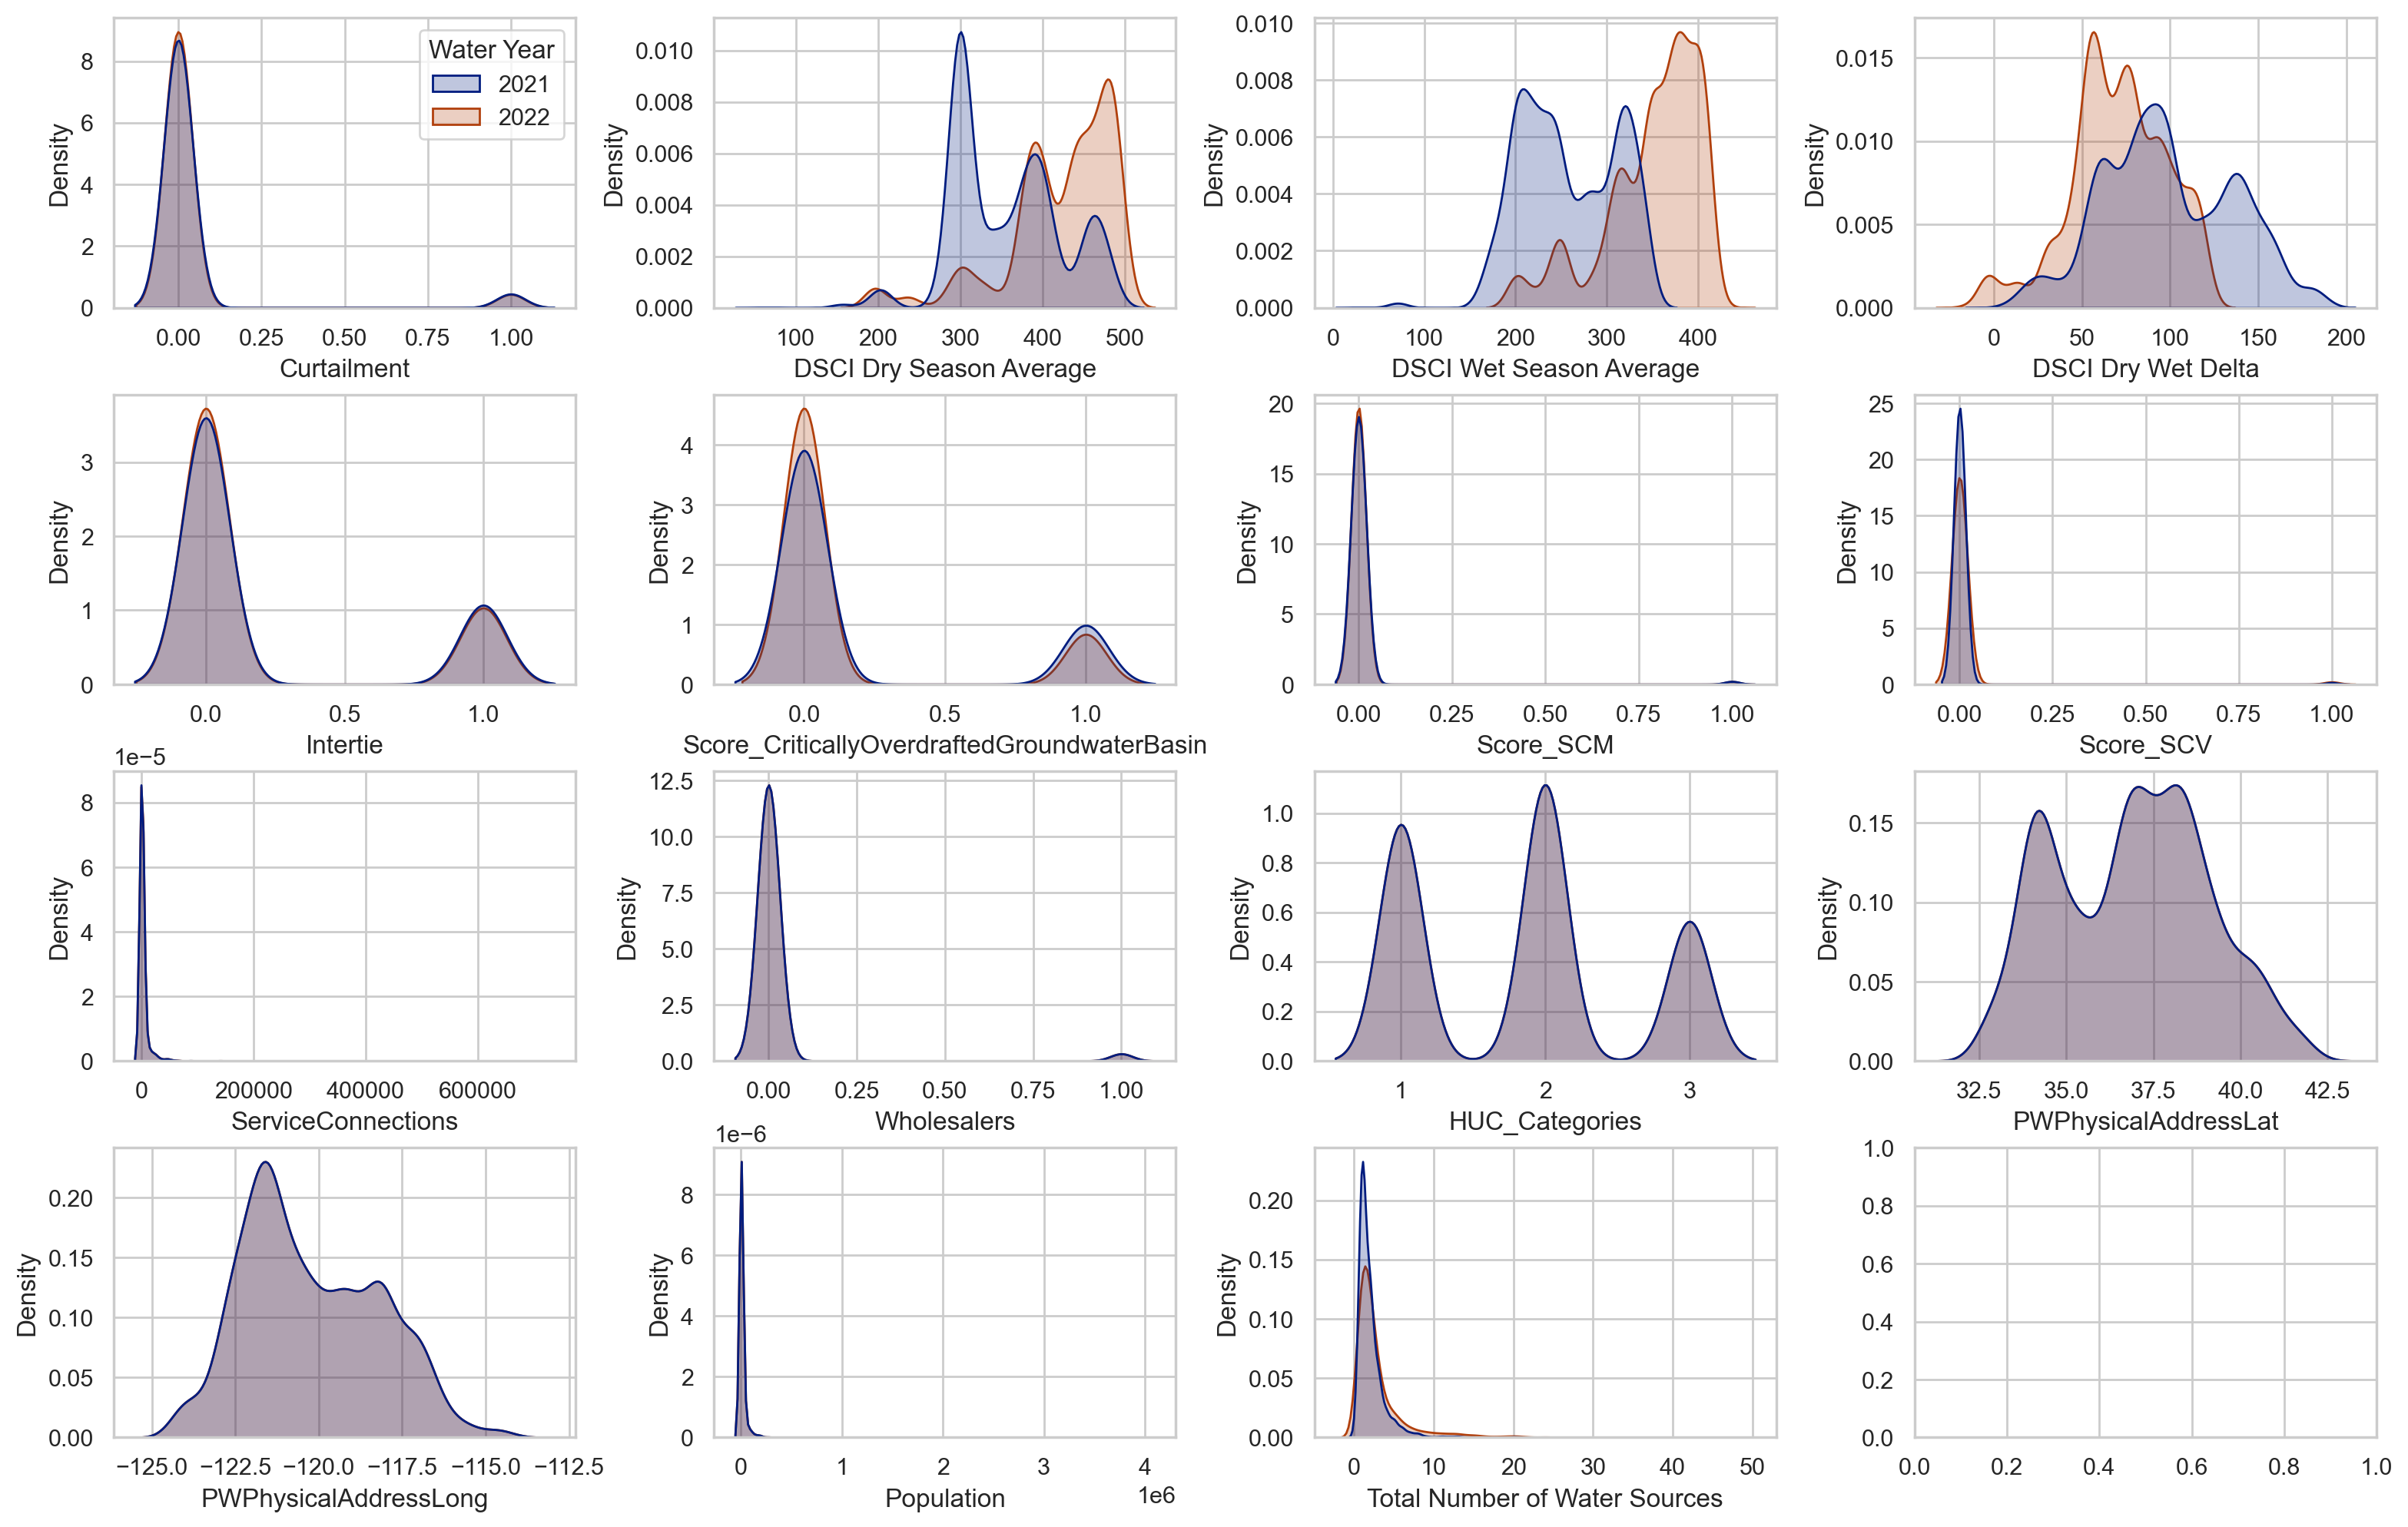

In [132]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(4,4, figsize=(19,12))
sns.kdeplot(df_combined, x='Curtailment', hue='Water Year', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='Water Year', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='Water Year', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='Water Year', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Intertie', hue='Water Year', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Water Year', fill=True, ax=ax[1,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCM', hue='Water Year', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCV', hue='Water Year', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='ServiceConnections', hue='Water Year', fill=True, ax=ax[2,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Wholesalers', hue='Water Year', fill=True, ax=ax[2,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='HUC_Categories', hue='Water Year', fill=True, ax=ax[2,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='Water Year', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='Water Year', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Population', hue='Water Year', fill=True, ax=ax[3,1], legend=False, palette='dark')
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='Water Year', fill=True, ax=ax[3,2], legend=False, palette='dark')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Features_per_WaterYear.png', dpi=300, transparent=True, bbox_inches='tight')

**Thinking about the label**

* `BottledHauledWaterOrZeroSource`: This describes whether a system currently relies on bottled water. 
* `WaterOutageDroughtViolation`: This directly describes whether a system had an outage due to drought.
* `CurtailmentExemptionPetition`: This is a petition to repeal the curtailment and unrelated to drought. The only ones who would appeal a curtailment are those who are already curtailed. `Curtailment` is a feature in the model, and highly correlated with the outcome label `CurtailmentExemptionPrediction`. A curtailment occurs when there is already a problem. According to the [DDW 2022 Water Right Curtailments Fact Sheet](https://www.waterboards.ca.gov/drought/resources-for-water-rights-holders/docs/curtailments-2022.pdf): "State Water Board staff evaluate water availability using current and forecasted hydrologic information, water use data from water right holders, environmental water needs, projected supplies, and more. When that evaluation shows there is not enough water to support all the known needs in a watershed, the State Water Board can send water right holders an order that prohibits water use. These orders are called Curtailment Orders."

<Axes: xlabel='CurtailmentExemptionPetition', ylabel='Density'>

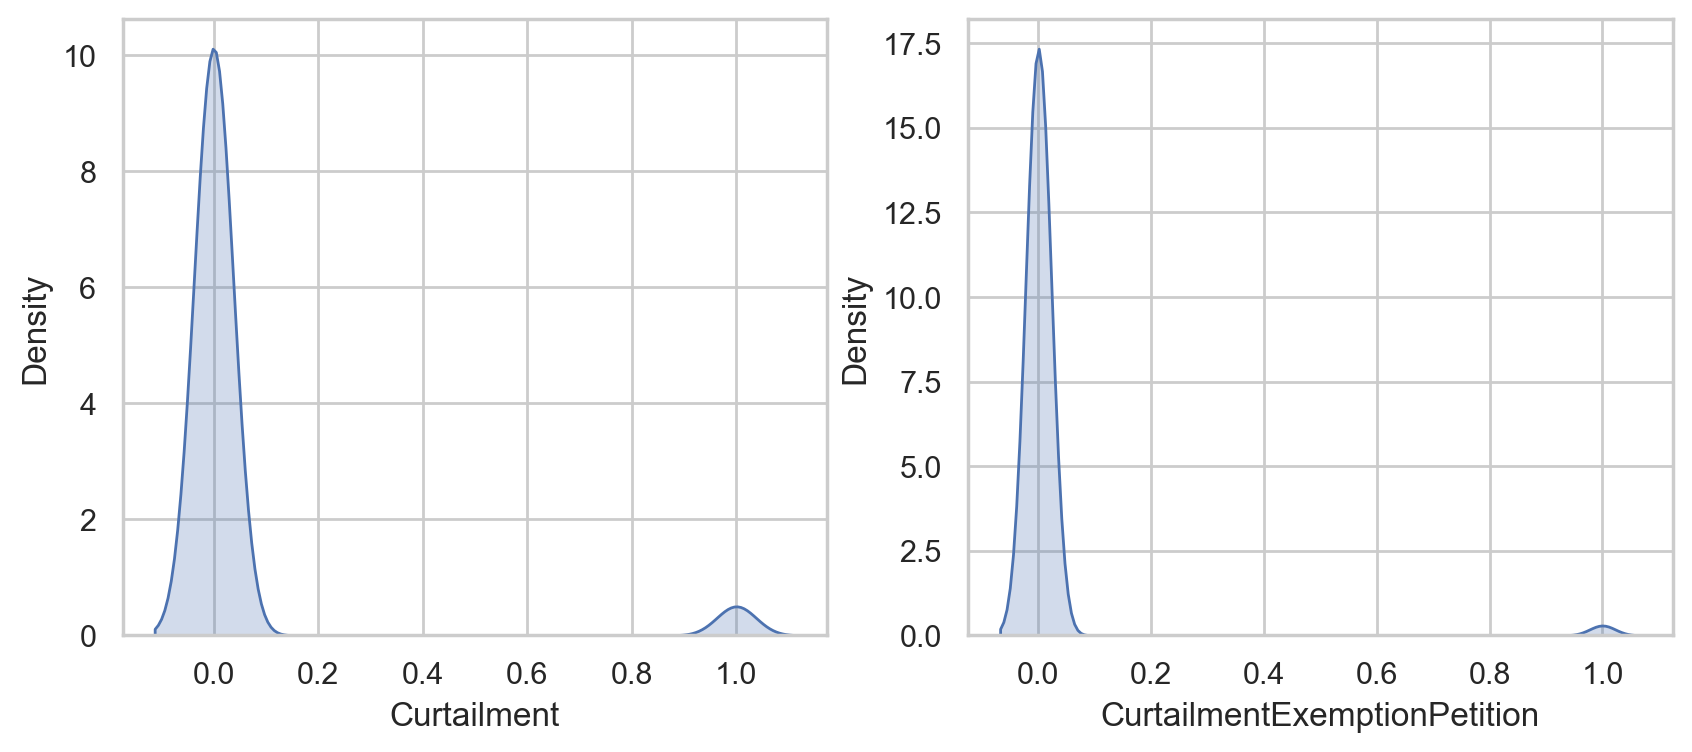

In [133]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(x=df_combined['Curtailment'], fill=True, legend=True, ax=ax[0])
sns.kdeplot(x=df_combined['CurtailmentExemptionPetition'], fill=True, legend=True, ax=ax[1])

In [134]:
print('Number of Curtailments in 2021: ',df_combined[df_combined['Water Year'] == 2021]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2021: ',df_combined[df_combined['Water Year'] == 2021]['CurtailmentExemptionPetition'].value_counts()[1])
print('Number of Curtailments in 2022: ',df_combined[df_combined['Water Year'] == 2022]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2022: ',df_combined[df_combined['Water Year'] == 2022]['CurtailmentExemptionPetition'].value_counts()[1])

Number of Curtailments in 2021:  139
Number of Petitions in 2021:  42
Number of Curtailments in 2022:  131
Number of Petitions in 2022:  53


Are there people who did not experience outages who wanted a petition? No. This is probably because a curtailment is a preventative measure. See:

```python
df_combined[df_combined['CurtailmentExemptionPetition'] == 1][['BottledHauledWaterOrZeroSource', 'WaterOutageDroughtViolation','Curtailment']]
```

Look at the difference in the labels between 2021 and 2022.

In [135]:
print('Year 2021')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2021]['DroughtExperienced'].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values| of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2021
Positive values of DroughtExperienced:  102
Positive values of WaterOutageDroughtViolation:  16
Positive values| of BottledHauledWaterOrZeroSource:  58
Positive values of CurtailmentExemptionPetition:  42


In [136]:
print('Year 2022')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2022
Positive values of DroughtExperienced:  122
Positive values of WaterOutageDroughtViolation:  3
Positive values of BottledHauledWaterOrZeroSource:  66
Positive values of CurtailmentExemptionPetition:  53


In [137]:
total = [
    df_combined[df_combined['Water Year'] == 2021][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1], 
    df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1]]    

year = [2021, 2021, 2021, 2021,
        2022, 2022, 2022, 2022]

labels = ['DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition',
          'DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition']

df_examples = pd.DataFrame(
    {'CWS': total,
     'Year': year,
     'Labels': labels})

Half of the label describes human behavior. We want to identify some empirical relationship between physical measurements -- like temperature, precipitation, and stream flow -- and drought impact. But physical processes cannot model human behavior. Whether someone files a petition for exemption from curtailment is a human behavior, and may not have any relationship with physical processes like the weather. 

<Axes: xlabel='CWS', ylabel='Labels'>

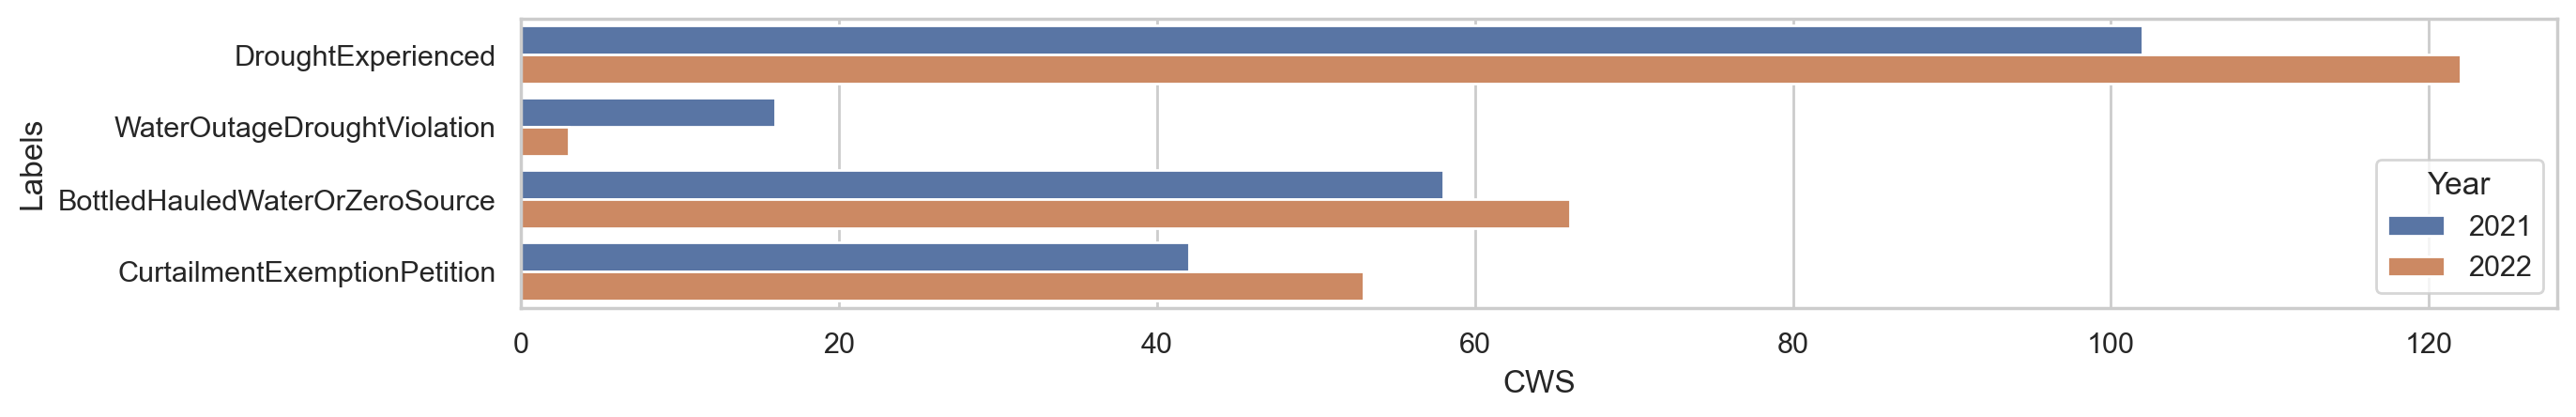

In [138]:
fig, ax = plt.subplots(figsize=(14,2))
sns.set_theme(style='whitegrid')

sns.barplot(orient="h", data=df_examples, x='CWS', y='Labels', hue='Year')
#fig.savefig('outcome.png', dpi=300, transparent=True, bbox_inches='tight')

#### B. Looking at CWS that experienced drought multiple years in a row

In [139]:
print("In 2021, ",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2021)]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [140]:
print("In 2022,",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2022)]['Population'].sum(),"people in California experienced some form of drought.")

In 2022, 1087825 people in California experienced some form of drought.


Most of the CWS experienced drought two years in a row. This means persistence (use of the previous outcome to predict the subsequent outcome) will be a useful feature.

In [141]:
total_CWS = len(df_combined)/2

In [142]:
safe_CWS_2021 = df_combined[(df_combined['DroughtExperienced'] == 0) & (df_combined['Water Year'] == 2021)]
safe_CWS_2022 = df_combined[(df_combined['DroughtExperienced'] == 0) & (df_combined['Water Year'] == 2022)]

In [143]:
number_of_safe_CWS_2021 = len(safe_CWS_2021)
number_of_safe_CWS_2022 = len(safe_CWS_2022)

In [144]:
print('{} CWS, or {:2.2%} of all CWS, experienced no issue in 2021.'.format(number_of_safe_CWS_2021, (number_of_safe_CWS_2021/total_CWS)))
print('{} CWS, or {:2.2%} of all CWS, experienced no issue in 2022.'.format(number_of_safe_CWS_2022, (number_of_safe_CWS_2022/total_CWS)))

2764 CWS, or 96.44% of all CWS, experienced no issue in 2021.
2744 CWS, or 95.74% of all CWS, experienced no issue in 2022.


Look at the breakdown for CWS that experienced drought:

In [145]:
number_of_drought_years = df_combined[(df_combined['DroughtExperienced'] == 1)][['CWSID', 'DroughtExperienced']].groupby('CWSID').sum()

In [146]:
number_of_safe_years = df_combined[(df_combined['DroughtExperienced'] == 0)][['CWSID', 'DroughtExperienced']].groupby('CWSID').sum()

In [147]:
number_of_no_years = len(number_of_safe_years[number_of_safe_years['DroughtExperienced'] == 0])

In [148]:
number_of_single_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1])
number_of_repeat_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2])
total_number = len(number_of_drought_years)

Identify the list of CWS that experienced drought in only one year:

In [149]:
list_cws_one_year = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1].index.to_list()

In [150]:
df_cws_one_year = df_combined[df_combined['CWSID'].isin(list_cws_one_year)]

In [151]:
number_cws_2021 = len(df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2021)])

In [152]:
list_cws_2021 = df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2021)]['CWSID'].to_list()

In [153]:
number_cws_2022 = len(df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2022)])

In [154]:
print('{} CWS, or {:2.2%} of all CWS, did not experience drought.'.format(number_of_no_years, (number_of_no_years/total_CWS)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in both years.'.format(number_of_repeat_years, (number_of_repeat_years/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in only one year.'.format(number_of_single_years, (number_of_single_years/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in 2021.'.format(number_cws_2021, (number_cws_2021/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in 2022.'.format(number_cws_2022, (number_cws_2022/total_number)))

2777 CWS, or 96.89% of all CWS, did not experience drought.
89 CWS, or 65.93% of all drought-experienced CWS, experienced drought in both years.
46 CWS, or 34.07% of all drought-experienced CWS, experienced drought in only one year.
13 CWS, or 9.63% of all drought-experienced CWS, experienced drought in 2021.
33 CWS, or 24.44% of all drought-experienced CWS, experienced drought in 2022.


Plot these values.

In [155]:
df_drought_years = pd.DataFrame({'Years of Drought':[0,1,2], 
                                   'CWS':[number_of_no_years, number_of_single_years, number_of_repeat_years]})

[Text(0, 0.5, 'Years of \n Drought')]

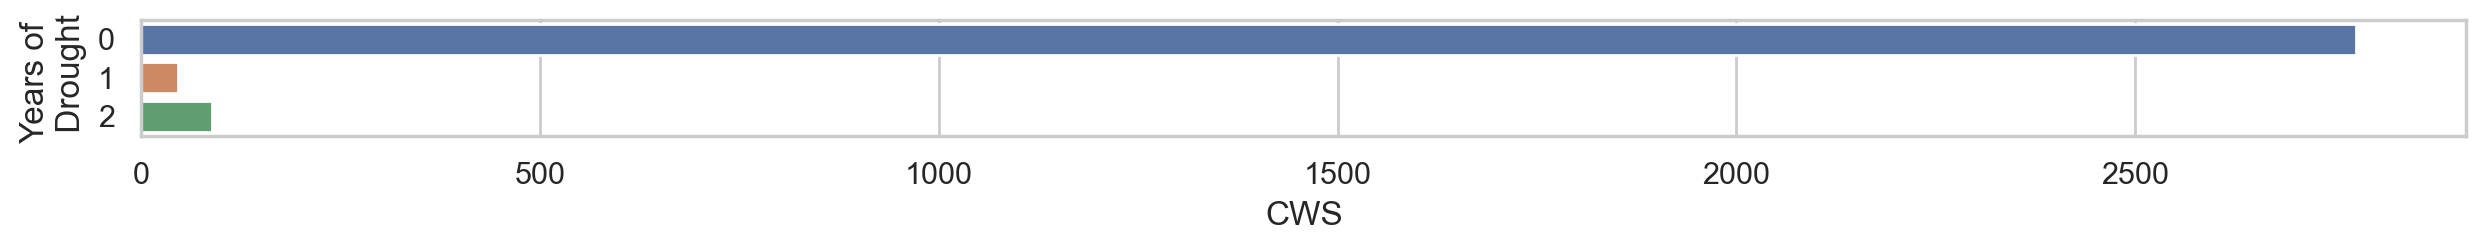

In [156]:
fig, ax = plt.subplots(figsize=(15,0.75))
sns.set_theme(style='whitegrid')
sns.barplot(orient="h", data=df_drought_years, x='CWS', y='Years of Drought')
ax.set(ylabel='Years of \n Drought')
#fig.savefig('droughtyears.png', dpi=300, transparent=True, bbox_inches='tight')

In addition, 28.26% of CWS that experienced drought only once had their experience in 2021. Comparatively, 71.74% of CWS that experienced drought only once had their experience in 2022.

In [157]:
df_single_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)
df_repeat_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)

In [158]:
single_CWSIDS_list = df_single_CWSIDS['CWSID'].to_list()
repeat_CWSIDS_list = df_repeat_CWSIDS['CWSID'].to_list()

In [159]:
single_CWSIDS_index = df_combined[df_combined['CWSID'].isin(single_CWSIDS_list)].index
repeat_CWSIDS_index = df_combined[df_combined['CWSID'].isin(repeat_CWSIDS_list)].index

In [160]:
df_combined['DroughtExperienced Years'] = 0

In [161]:
df_combined.loc[single_CWSIDS_index, ('DroughtExperienced Years')] = 1
df_combined.loc[repeat_CWSIDS_index, ('DroughtExperienced Years')] = 2

Did the CWSIDs that experienced drought in both 2021 and 2022 experience it for the same reason?

There are a couple CWSIDs that experienced a water drought violation in 2021 and then relied on bottled or hauled water in 2022. We also see many CWSIDs that are relying on bottled or hauled water, but do not have a flag for a water outage drought violation. Why is that?

In [162]:
multi_reason_CWSIDS = []

for i in range(len(repeat_CWSIDS_list)):
    df_tmp = df_combined[df_combined['CWSID'] == repeat_CWSIDS_list[i]].reset_index()
    if (df_tmp['BottledHauledWaterOrZeroSource'][0] != df_tmp['BottledHauledWaterOrZeroSource'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['CurtailmentExemptionPetition'][0] != df_tmp['CurtailmentExemptionPetition'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['WaterOutageDroughtViolation'][0] != df_tmp['WaterOutageDroughtViolation'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])

In [163]:
print('There are {} CWS that were flagged for different reasons from year to year. {} CWS rest were flagged for the same reason.'.format(len(multi_reason_CWSIDS), len(repeat_CWSIDS_list)/2))

There are 32 CWS that were flagged for different reasons from year to year. 89.0 CWS rest were flagged for the same reason.


Is there any difference between the CWS that are drought-impacted both years, drought-impacted one year, and not drought-impacted?

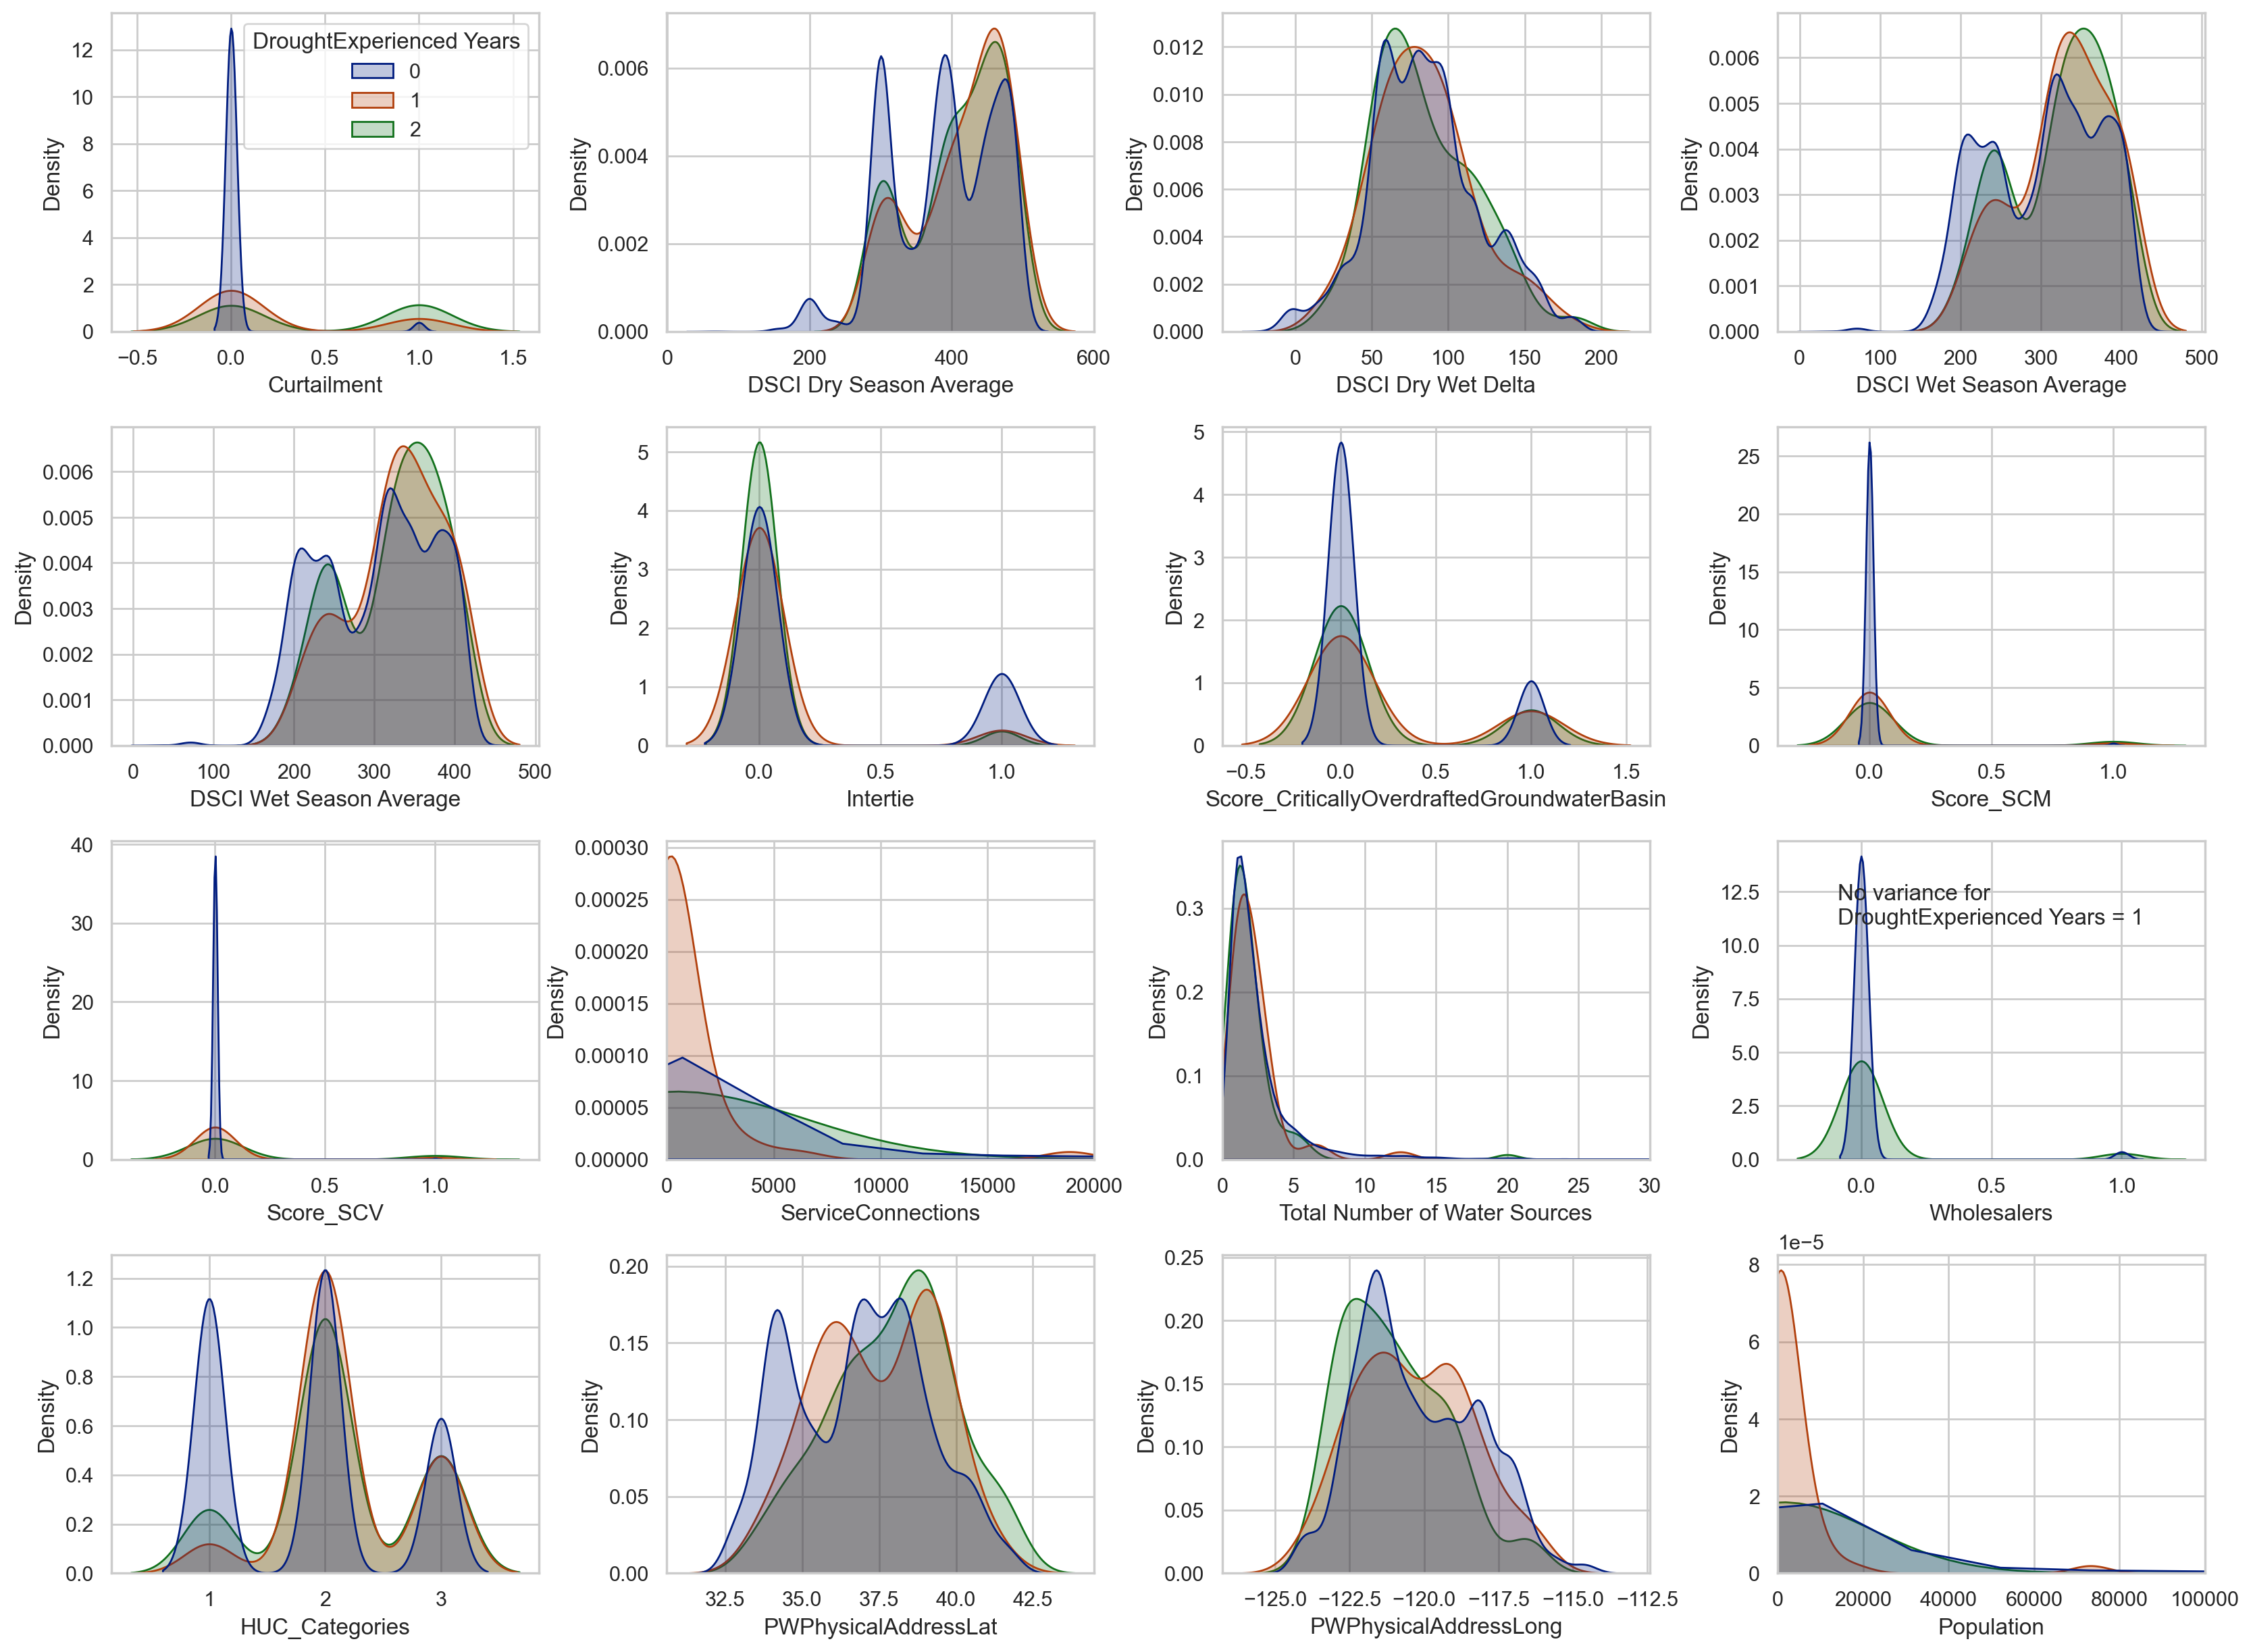

In [164]:
fig, ax = plt.subplots(4,4, figsize=(20,15))
sns.kdeplot(df_combined, x='Curtailment', hue='DroughtExperienced Years', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='DroughtExperienced Years', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Intertie', hue='DroughtExperienced Years', fill=True, ax=ax[1,1,], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='DroughtExperienced Years', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_SCM', hue='DroughtExperienced Years', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_SCV', hue='DroughtExperienced Years', fill=True, ax=ax[2,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='ServiceConnections', hue='DroughtExperienced Years', fill=True, ax=ax[2,1], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,1].set_xlim([0,20000])
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='DroughtExperienced Years', fill=True, ax=ax[2,2], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,2].set_xlim([0,30])
sns.kdeplot(df_combined, x='Wholesalers', hue='DroughtExperienced Years', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,3].annotate('No variance for \nDroughtExperienced Years = 1', xy=(-0.09, 11))
sns.kdeplot(df_combined, x='HUC_Categories', hue='DroughtExperienced Years', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='DroughtExperienced Years', fill=True, ax=ax[3,1], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='DroughtExperienced Years', fill=True, ax=ax[3,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Population', hue='DroughtExperienced Years', fill=True, ax=ax[3,3], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[3,3].set_xlim([0,100000])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('DroughtExperienced_years.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Create a training and validation dataset. 

* We ask the model to learn the relationship between everything that happened in 2021 and the label for 2022. Critically, this means that we treat the outcome, or label, for 2021 as a feature. Therefore, we train the model on 70% of the data from 2021 and 70% of the labels 2022. In addition, we make sure as many HUC8 codes as posible are represented in the training set. Note that there are a dozen HUC8 codes with only one CWS, so these cannot be represented in both samples. To do this, we temporarily add `HUC8`, `CWSID`, `Water Year` to the list of features, so we can stratify this feature across the training and testing sets and verify the results. After that, we will drop these three features from our data.
* We test the model by giving it the remaining 30% of data from 2021 and asking the model to predict the 2022 labels.
* Note that we do not use the 2022 features here. We will use the 2022 features and labels, together with the 2021 features and labels, to predict the 2023 outcome.

In [165]:
temporary_features = ['CWSID', 'Water Year', 'HUC8']

numeric_features = ['ServiceConnections', 'Population',
                    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
                    'DSCI Dry Season Average', 'DSCI Wet Season Average',
                    'DSCI Dry Wet Delta', 'Total Number of Water Sources']

categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'DroughtExperienced']

all_features = temporary_features + numeric_features + categorical_features

In [166]:
# Construct all the examples
X = df_combined[all_features][df_combined['Water Year'] == 2021]

# Construct all the labels
y = df_combined[['CWSID', 'Water Year', 'HUC8', 'DroughtExperienced']][df_combined['Water Year'] == 2022]

Right now there are two flavors of `DroughtExperienced` in the model:
1. The outcome label for 2021, which is a feature, and
2. The outcome label for 2022, which is a label.

To avoid confusion, rename the feature `DroughtExperienced` as `Outcome` and redefine the categorical features to include `Outcome`:

In [167]:
X = X.rename(columns={'DroughtExperienced' : 'Outcome'})

In [168]:
categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'Outcome']

Now split the training and validation sets, stratifying by `HUC_Categories`:

In [169]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.36, random_state=77, stratify=X['HUC_Categories'])

Print some summary statistics about the data:

In [170]:
print('There are {} positive examples in the training set.'.format(y_train['DroughtExperienced'].value_counts()[1]))
print('There are {} positive examples in the test set.'.format(y_val['DroughtExperienced'].value_counts()[1]))

There are 77 positive examples in the training set.
There are 45 positive examples in the test set.


In [171]:
print('There are {} negative examples in the training set.'.format(y_train['DroughtExperienced'].value_counts()[0]))
print('There are {} negative examples in the test set.'.format(y_val['DroughtExperienced'].value_counts()[0]))

There are 1757 negative examples in the training set.
There are 987 negative examples in the test set.


In [172]:
x_validation_set_tmp = X_val[['CWSID', 'Outcome']]
y_validation_set_tmp = y_val[['CWSID', 'DroughtExperienced']]
out = x_validation_set_tmp.merge(y_validation_set_tmp, on='CWSID')
print('There are {} positive examples in the test set that were also positive in the previous year.'.format(len(out[(out['DroughtExperienced'] == 1) & (out['Outcome'] == 1)])))

There are 35 positive examples in the test set that were also positive in the previous year.


In [173]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")
print("")
print(f"The entire dataset includes {len(X['HUC8'].unique())} unique HUC8 codes.")
print(f"The training set includes {len(X_train['HUC8'].unique())} unique HUC8 codes.")
print(f"The validation set includes {len(X_val['HUC8'].unique())} unique HUC8 codes.")

The training set is 63.991625959525464% of the data.
The validation set is 36.00837404047453% of the data.

The entire dataset includes 125 unique HUC8 codes.
The training set includes 120 unique HUC8 codes.
The validation set includes 112 unique HUC8 codes.


Reset the indices on the train validation split so that they align nicely.
Note that this means they are decoupled from `df_combined`.

In [174]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Make a copy of of all these dataframes in order to print the probabilities per CWS.
Then drop the temporary features.

In [175]:
df_X_train = X_train
df_y_train = y_train
df_X_val = X_val
df_y_val = y_val

In [176]:
X_train = X_train.drop(columns=temporary_features)
y_train = y_train.drop(columns=temporary_features)
X_val = X_val.drop(columns=temporary_features)
y_val = y_val.drop(columns=temporary_features)
X = X.drop(columns=temporary_features)
y = y.drop(columns=temporary_features)

Unravel the label

In [177]:
y_val = y_val.values.ravel()
y_train = y_train.values.ravel()
y = y.values.ravel()

### Scale the data

#### Scale the training data

In [178]:
def scale_the_training_data(numeric_features, categorical_features, X_train):
    """
    Scale the training data.

    Scale the numeric features assuming the data obey a Gaussian distribution.
    Leave the categorical features unscaled.

    Parameters
    ----------
    numeric_features : list
        List of numeric features.
    categorical_features : list
        List of categorical features.
    X_train : pandas.DataFrame
        Dataframe containing the training set.

    Returns
    -------
    X_train_scaled : pandas.DataFrame
        Dataframe containing the scaled training set.
    scaler : sklearn.preprocessing.StandardScaler
        The scaler used to scale the training set.
    
    Examples
    --------
    >>> X_train_scaled, scaler = scale_the_data(numeric_features, categorical_features, X_train)
    """

    # Combine the numeric and categorical features
    numeric_and_categorical_features = numeric_features + categorical_features

    # Check to make sure the list of features is not empty
    if not numeric_features:
        raise ValueError('The list of numeric features is empty.')
    if not categorical_features:
        raise ValueError('The list of categorical features is empty.')
    
    # Define a standard scaler
    scaler = preprocessing.StandardScaler()

    # Select the numeric features
    X_train_numeric = X_train[numeric_features]

    # Scale the numeric features using fit_transform()
    X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)

    # Select the unscaled categorical features
    X_train_categorical = np.array(X_train[categorical_features])

    # Append the unscaled cateogrical features
    X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)

    return X_train_scaled, scaler

In [179]:
X_train_scaled, scaler = scale_the_training_data(numeric_features, categorical_features, X_train)

#### Scale the validation data

In [180]:
def scale_the_validation_data(numeric_features, categorical_features, X_val, scaler):
    """
    Scale the validation data using the same uses the same mean and variance as the training set.

    Parameters
    ----------
    numeric_features : list
        List of numeric features.
    categorical_features : list
        List of categorical features.
    X_val : pandas.DataFrame
        Dataframe containing the validation set.
    scaler : sklearn.preprocessing.StandardScaler
        The scaler used to scale the training set.

    Returns
    -------
    X_val_scaled : pandas.DataFrame
        Dataframe containing the scaled training set.
    
    Examples
    --------
    >>> X_val_scaled = scale_the_data(numeric_features, categorical_features, X_val, scaler)
    """
    # Check to make sure the list of features is not empty
    if not numeric_features:
        raise ValueError('The list of numeric features is empty.')
    if not categorical_features:
        raise ValueError('The list of categorical features is empty.')
    
    # Select the numeric features
    X_val_numeric = X_val[numeric_features]

    # Scale the numeric features in the validation set using transform(),
    # which uses the same mean and variance as the training set.
    X_val_numeric_scaled = scaler.transform(X_val_numeric)

    # Select the unscaled categorical features
    X_val_categorical = np.array(X_val[categorical_features])

    # Append the unscaled cateogrical features
    X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

    return X_val_scaled

In [181]:
X_val_scaled = scale_the_validation_data(numeric_features, categorical_features, X_val, scaler)

### Train the model

We use a SVM to train and test the model. Note that the class imbalance ratio here is roughly 1:20. Previous experiments (in previous versions of this Jupyter notebook, e.g. [here](https://github.com/cagov/aae-dsa-water/blob/adb979f8c91bc53318881f5515c7fd284b72b5bb/water.ipynb)) used GridSearchCV to search the hyperparameter space and studied the tradeoffs between regularization parameters and positive class weight. Those experiments led to a regularization parameter C equal to 4.0, and negative to positive class weight ratio of 1:5.

In [182]:
def train_the_model(X_train_scaled, y_train):
    """
    Train the model.

    Parameters
    ----------
    X_train_scaled : pandas.DataFrame
        Dataframe containing the scaled training set.
    y_train : pandas.DataFrame
        Dataframe containing the training labels.
    
    Returns
    -------
    clf : sklearn.svm.SVC
        The trained model.
    
    Examples
    --------
    >>> clf = train_the_model(X_train_scaled, y_train)
    """

    # Initialize the model
    clf = svm.SVC(gamma='auto', kernel='rbf', C=4.0, class_weight={0:1, 1: 5}, probability=True, random_state=17)

    # Fit the model
    clf.fit(X_train_scaled, y_train)

    return clf

In [183]:
clf = train_the_model(X_train_scaled, y_train)

### Predict the outcome

In [184]:
y_pred_probability = clf.predict_proba(X_val_scaled)

#### Generate a list of the CWS most likely to fail in 2022.

In [185]:
cwsids = []
ground_truth = []
not_expected = []
expected = []
prediction = []

for i in range(len(y_val)):
    cwsids.append(df_y_val[['CWSID']].iloc[i][0])
    ground_truth.append(y_val[i])
    not_expected.append(y_pred_probability[i][0])
    expected.append(y_pred_probability[i][1])
    if (y_pred_probability[i][0] > 0.5):
        prediction.append('Not Expected')
    if (y_pred_probability[i][1] >= 0.5):
        prediction.append('Expected')

In [186]:
df_predictions_2022 = pd.DataFrame({'CWSID':cwsids, 'Ground Truth':ground_truth, 'Not Expected': not_expected, 'Expected': expected, 'Prediction': prediction})

In [187]:
df_predictions_2022 = df_predictions_2022.sort_values(by=['Expected'], ascending=False).reset_index(drop=True)

### Question 2: What does the model get wrong?

Figure out if there are any differences in the distribution of true positives, true negatives, false positives, and false negatives.

In [188]:
def probability_based_confusion_matrix(y_val=y_val, y_pred_probablity=y_pred_probability):
    """
    This function takes in the validation set and the predicted probabilities
    and returns indices of the false positives, false negatives, true positives, and true negatives.

    Parameters:
    y_val: The validation set
    y_pred_probability: The predicted probabilities

    Returns:
    examples_false_positive: The indices of the false positives
    examples_false_negative: The indices of the false negatives
    examples_true_positive: The indices of the true positives
    examples_true_negative: The indices of the true negatives

    Example:
    >>> probability_based_confusion_matrix(y_val, y_pred_probability)
    """
    
    # Set counter
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0
    examples_false_positive = []
    examples_false_negative = []
    examples_true_positive = []
    examples_true_negative = []

    for i in range(len(y_val)):
        if ((y_val[i] == 0) and (y_pred_probability[i][0] <= 0.5)):
            count_false_positive += 1
            examples_false_positive.append(i)
        if ((y_val[i] == 1) and (y_pred_probability[i][1] <= 0.5)):
            count_false_negative += 1
            examples_false_negative.append(i)
        if ((y_val[i] == 0) and (y_pred_probability[i][0] >= 0.5)):
            count_true_negative += 1
            examples_true_negative.append(i)
        if ((y_val[i] == 1) and (y_pred_probability[i][1] >= 0.5)):
            count_true_positive += 1
            examples_true_positive.append(i)
    print('There were {} false positives.'.format(count_false_positive))
    print('There were {} false negatives.'.format(count_false_negative))
    print('There were {} true positives.'.format(count_true_positive))
    print('There were {} true negatives.'.format(count_true_negative))

    # Reset counter
    count = 0
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0

    return examples_false_positive, examples_false_negative, examples_true_positive, examples_true_negative

In [189]:
examples_false_positive, examples_false_negative, examples_true_positive, examples_true_negative = probability_based_confusion_matrix(y_val=y_val, y_pred_probablity=y_pred_probability)

There were 7 false positives.
There were 13 false negatives.
There were 32 true positives.
There were 981 true negatives.


In [190]:
df_false_positives = df_X_val.loc[examples_false_positive].reset_index(drop=True).assign(Classification='False Positive')
df_false_negatives = df_X_val.loc[examples_false_negative].reset_index(drop=True).assign(Classification='False Negative')
df_true_positives = df_X_val.loc[examples_true_positive].reset_index(drop=True).assign(Classification='True Positive')
df_true_negatives = df_X_val.loc[examples_true_negative].reset_index(drop=True).assign(Classification='True Negative')

In [191]:
frames = [df_false_positives, df_false_negatives, df_true_positives, df_true_negatives]
df_all = pd.concat(frames)

In [192]:
# Replace populations of 0 with 0.1 to account for the log plot
df_all['Population'] = df_all['Population'].replace(0, 0.1)

In [193]:
# Replace service connections of 0 with 0.1 to account for the log plot
df_all['ServiceConnections'] = df_all['ServiceConnections'].replace(0, 0.1)

Look at the false negatives:

In [194]:
df_all[df_all['Classification'] == 'False Negative']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome,Classification
0,CA2310006,2021,18010110,1609.0,5500.0,39.125805,-123.205817,300.000000,246.010769,53.989231,20.0,0.0,0.0,0,0.0,0.0,1,3,1,False Negative
1,CA4700503,2021,18010208,34.0,70.0,41.309588,-122.801418,400.000000,329.102692,70.897308,1.0,0.0,1.0,0,0.0,0.0,1,3,0,False Negative
2,CA4600017,2021,18020125,120.0,324.0,39.574504,-120.615826,307.907273,229.781538,78.125734,2.0,0.0,0.0,0,0.0,0.0,1,2,0,False Negative
3,CA0910013,2021,18020128,3733.0,9112.0,38.912373,-120.833732,314.318182,216.788846,97.529336,1.0,0.0,0.0,0,0.0,0.0,1,2,0,False Negative
4,CA3600114,2021,18100201,165.0,695.0,34.076247,-116.552461,294.676818,252.918462,41.758357,2.0,0.0,0.0,0,0.0,0.0,0,3,0,False Negative
5,CA5401003,2021,18030007,103.0,932.0,36.548304,-119.262064,468.468636,314.529615,153.939021,2.0,0.0,0.0,1,0.0,0.0,0,2,0,False Negative
6,CA4400571,2021,18050006,108.0,350.0,37.019132,-122.205399,300.000000,217.634231,82.365769,2.0,0.0,0.0,0,0.0,0.0,0,1,0,False Negative
7,CA5403144,2021,18030006,13.0,39.0,36.211397,-119.260021,459.883636,321.320000,138.563636,1.0,0.0,0.0,1,0.0,0.0,0,2,0,False Negative
8,CA5400544,2021,18030005,164.0,521.0,35.850411,-119.384157,446.157273,330.364615,115.792657,2.0,0.0,0.0,1,0.0,0.0,0,2,0,False Negative
9,CA3910012,2021,18040003,49167.0,183046.0,37.936480,-121.325984,366.423636,277.444615,88.979021,1.0,0.0,0.0,1,1.0,0.0,1,2,1,False Negative


Are these 13 false negatives the same ones that experienced drought in only 2021? No.

In [195]:
df_all[df_all['Classification'] == 'False Negative']['CWSID'].isin(list_cws_2021)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
Name: CWSID, dtype: bool

Look at the false positives:

In [196]:
df_all[df_all['Classification'] == 'False Positive']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome,Classification
0,CA3610125,2021,18090208,3382.0,12513.0,34.514030,-117.363240,352.995000,287.754615,65.240385,1.0,0.0,1.0,0,0.0,0.0,0,3,0,False Positive
1,CA1500442,2021,18090206,20.0,37.0,35.009511,-117.837943,406.360000,311.637692,94.722308,1.0,0.0,0.0,0,0.0,0.0,0,3,1,False Positive
2,CA1500458,2021,18030001,24.0,67.0,35.706896,-118.456197,472.813182,293.557692,179.255490,1.0,0.0,0.0,0,0.0,0.0,0,2,1,False Positive
3,CA1500455,2021,18090206,16.0,56.0,34.941642,-118.254592,406.360000,311.637692,94.722308,1.0,0.0,0.0,0,0.0,0.0,0,3,1,False Positive
4,CA4900568,2021,18010108,23.0,61.0,39.348357,-123.803266,300.000000,209.446923,90.553077,3.0,0.0,0.0,0,0.0,0.0,0,3,1,False Positive
5,CA4700513,2021,18020154,147.0,280.0,40.575264,-122.357484,400.000000,338.580000,61.420000,3.0,1.0,0.0,0,0.0,0.0,0,2,1,False Positive
6,CA4100529,2021,18050006,21.0,186.0,37.275809,-122.283000,300.000000,217.634231,82.365769,1.0,0.0,0.0,0,0.0,0.0,0,1,1,False Positive


Are these 6 false negatives among those that experienced drought only in 2022? Yes.

In [197]:
df_all[df_all['Classification'] == 'False Positive']['CWSID'].isin(list_cws_2021)

0    False
1     True
2     True
3     True
4     True
5     True
6     True
Name: CWSID, dtype: bool

Look at the true positives:

In [198]:
df_all[df_all['Classification'] == 'True Positive']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome,Classification
0,CA5400523,2021,18030007,47.0,100.0,36.546678,-119.425346,468.468636,314.529615,153.939021,1.0,0.0,0.0,1,0.0,0.0,0,2,1,True Positive
1,CA1900062,2021,18070102,22.0,184.0,34.478605,-118.463357,380.857727,244.983462,135.874266,0.0,1.0,0.0,0,0.0,0.0,0,1,1,True Positive
2,CA4300573,2021,18060002,19.0,53.0,37.109972,-121.683960,339.029091,237.603846,101.425245,2.0,1.0,0.0,0,0.0,0.0,0,1,1,True Positive
3,CA1500371,2021,18030003,26.0,208.0,35.224821,-118.614810,482.261364,342.023846,140.237517,0.0,0.0,0.0,0,0.0,0.0,0,2,1,True Positive
4,CA1900520,2021,18090206,34.0,50.0,34.734612,-118.134955,406.360000,311.637692,94.722308,1.0,0.0,0.0,0,0.0,0.0,0,3,1,True Positive
5,CA4500101,2021,18020005,50.0,121.0,40.855768,-122.339211,400.000000,340.826154,59.173846,2.0,1.0,0.0,0,0.0,0.0,0,2,1,True Positive
6,CA2700771,2021,18060015,34.0,200.0,36.839090,-121.667685,300.000000,200.637692,99.362308,1.0,0.0,0.0,1,0.0,0.0,0,1,1,True Positive
7,CA4900646,2021,18010110,16.0,37.0,38.646292,-122.814400,300.000000,246.010769,53.989231,2.0,0.0,0.0,0,0.0,0.0,1,3,1,True Positive
8,CA3500527,2021,18060002,17.0,55.0,36.836065,-121.419435,339.029091,237.603846,101.425245,1.0,0.0,0.0,0,0.0,0.0,0,1,1,True Positive
9,CA1710003,2021,18020116,2878.0,9494.0,38.953230,-122.636157,333.713636,315.016154,18.697483,3.0,0.0,0.0,0,1.0,0.0,1,2,1,True Positive


Did all these true positives also experience drought in the previous year? Yes.

What percentage of the test set do we misclassify?

In [199]:
print("We misclassify {}% of the test set.".format(((len(examples_false_positive) + len(examples_false_negative)) / (len(examples_false_positive) + len(examples_false_negative) + len(examples_true_positive) + len(examples_true_negative)))*100))

We misclassify 1.9361084220716358% of the test set.


Plot all of the features per classification type:

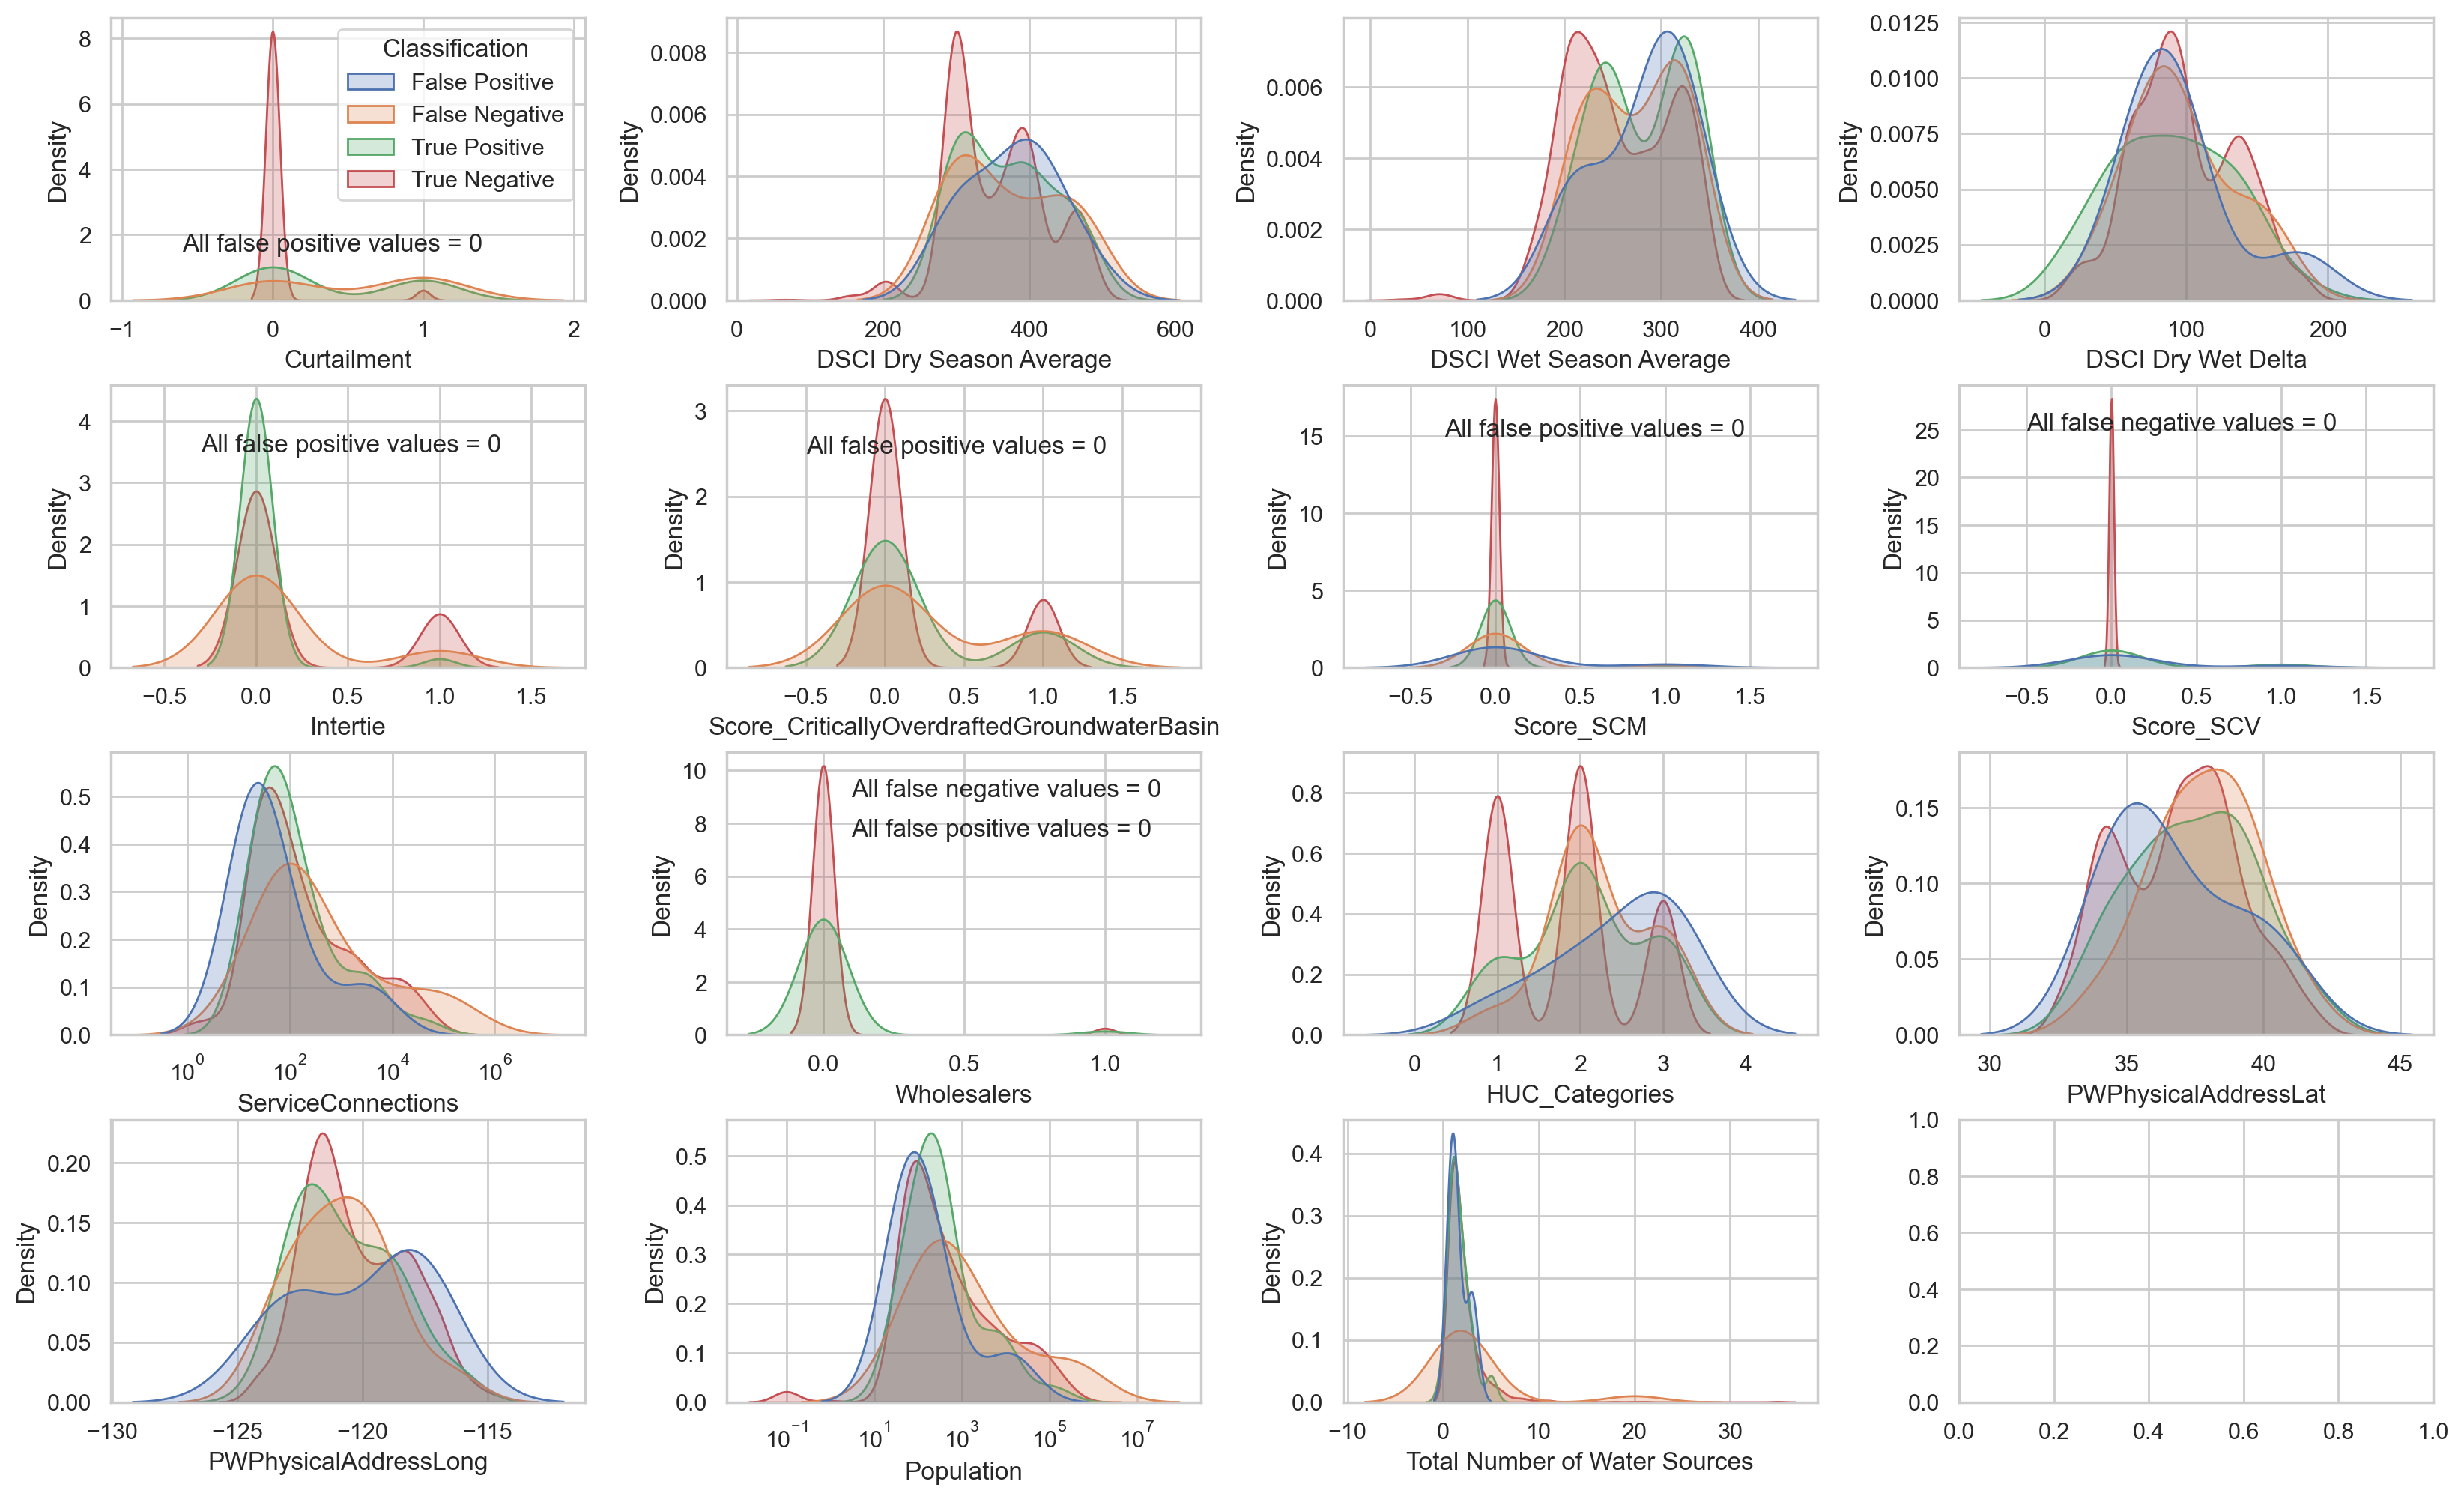

In [200]:
fig, ax = plt.subplots(4,4, figsize=(20,12))
sns.kdeplot(df_all, x='Curtailment', hue='Classification', fill=True, ax=ax[0,0], legend=True, common_norm=False, warn_singular=False)
ax[0,0].annotate('All false positive values = 0', xy=(-0.6, 1.5))
sns.kdeplot(df_all, x='DSCI Dry Season Average', hue='Classification', fill=True, ax=ax[0,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI Wet Season Average', hue='Classification', fill=True, ax=ax[0,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI Dry Wet Delta', hue='Classification', fill=True, ax=ax[0,3], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Intertie', hue='Classification', fill=True, ax=ax[1,0], legend=False, common_norm=False, warn_singular=False)
ax[1,0].annotate('All false positive values = 0', xy=(-0.3, 3.5))
sns.kdeplot(df_all, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Classification', fill=True, ax=ax[1,1], legend=False, common_norm=False, warn_singular=False)
ax[1,1].annotate('All false positive values = 0', xy=(-0.5, 2.5))
sns.kdeplot(df_all, x='Score_SCM', hue='Classification', fill=True, ax=ax[1,2], legend=False, common_norm=False, warn_singular=False)
ax[1,2].annotate('All false positive values = 0', xy=(-0.3, 15.0))
sns.kdeplot(df_all, x='Score_SCV', hue='Classification', fill=True, ax=ax[1,3], legend=False, common_norm=False, warn_singular=False)
ax[1,3].annotate('All false negative values = 0', xy=(-0.5, 25.0))
sns.kdeplot(df_all, x='ServiceConnections', hue='Classification', fill=True, ax=ax[2,0], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='Wholesalers', hue='Classification', fill=True, ax=ax[2,1], legend=False, common_norm=False, warn_singular=False)
ax[2,1].annotate('All false positive values = 0', xy=(0.1, 7.5))
ax[2,1].annotate('All false negative values = 0', xy=(0.1, 9.0))
sns.kdeplot(df_all, x='HUC_Categories', hue='Classification', fill=True, ax=ax[2,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLat', hue='Classification', fill=True, ax=ax[2,3], legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLong', hue='Classification', fill=True, ax=ax[3,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Population', hue='Classification', fill=True, ax=ax[3,1], legend=False, log_scale=True, common_norm=False)
sns.kdeplot(df_all, x='Total Number of Water Sources', hue='Classification', fill=True, ax=ax[3,2], legend=False, common_norm=False)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Misclassifications_2022.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 3: What are the most predictive features?

We assess predictive capacity based the Univariate F Score.

[Text(0.5, 0, 'Normalized Fisher Score')]

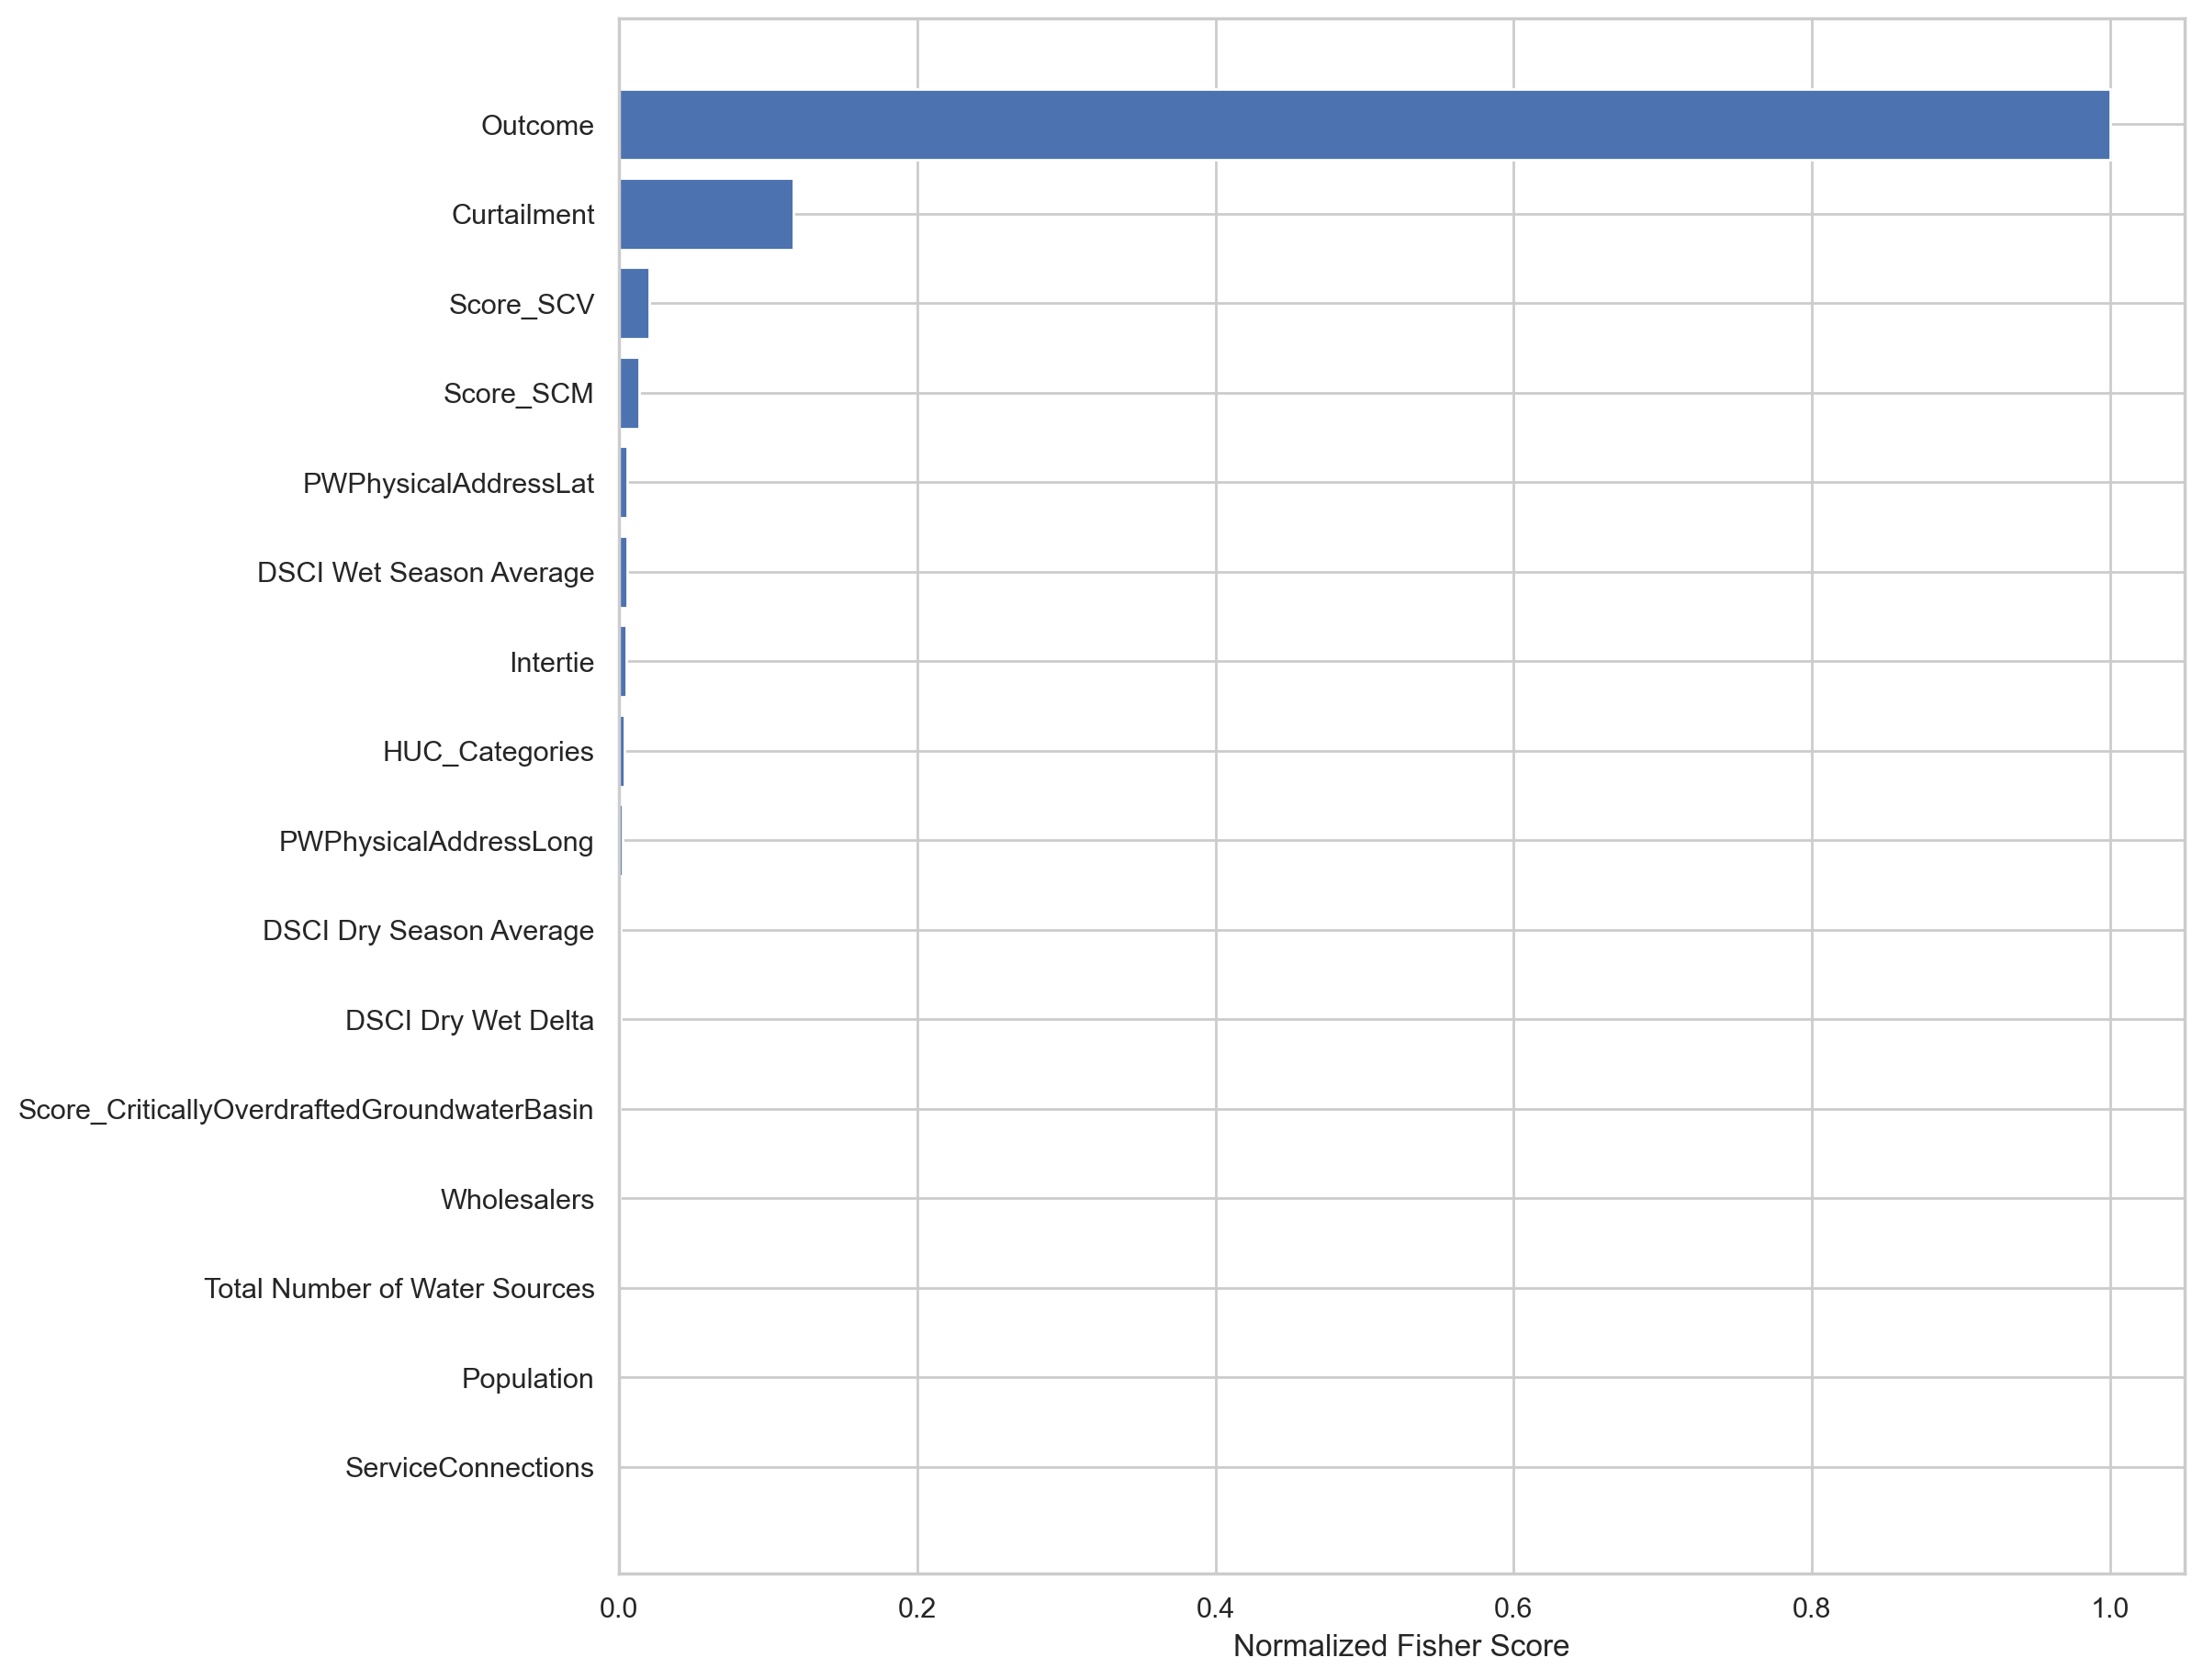

In [201]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

# Select method and fit
selector=SelectKBest(f_classif, k='all')
selector.fit(X, y)
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

# Select, sort, and normalize features
features = X_train.columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

### Re-train model

Now that we have validated the model and confirmed that it performs reasonably well, we can re-train it with all the data to predict the outcome for 2023. This means we will have 100% training data and 0% test data. Although we do not split the data, we do scale it again.

* The training data then includes 100% of the features for 2021, including the outcome of 2021, to predict 100% of the labels for 2022.
* The trained model will then run on 100% of the features for 2022, including the outcome of 2022, to predict 100% of the lables for 2023.

Construct the training set.

In [202]:
# Construct the features
X_train = df_combined[all_features][df_combined['Water Year'] == 2021]
X_train = X_train.rename(columns={'DroughtExperienced' : 'Outcome'})
X_train = X_train.drop(columns=temporary_features)

# Construct and unravel the label
y_train = df_combined[['DroughtExperienced']][df_combined['Water Year'] == 2022].reset_index(drop=True)
y_train = y_train.values.ravel()

Scale the data.

In [203]:
X_train_scaled, _ = scale_the_training_data(numeric_features, categorical_features, X_train)

Train the model.

In [204]:
model = train_the_model(X_train_scaled, y_train)

### Predict the 2023 outcomes

In [205]:
def generate_test_set(all_features, df_combined, water_year):
    """
    Generates a test set for a given year.

    Parameters
    ----------
    all_features : list
        List of all features.
    df_combined : pandas.DataFrame
        Dataframe containing the combined data.
    water_year : int
        The year of data to use for the test set.

    Returns
    -------
    df_X_test : pandas.DataFrame
        Dataframe containing the test set.
    df_X_test_plus_temporary_features : pandas.DataFrame
        Dataframe containing the test set plus temporary features.
    
    Examples
    --------
    >>> df_X_test, df_X_test_plus_temporary_features = generate_test_set(all_features=all_features, df_combined=df_combined, water_year=2022)

    """
    # Identify the water year
    df_X_test_plus_temporary_features = df_combined[df_combined['Water Year'] == 2022]
    
    # Select all features
    df_X_test_plus_temporary_features = df_X_test_plus_temporary_features[all_features]
    
    # Construct the features
    df_X_test_plus_temporary_features = df_X_test_plus_temporary_features.rename(columns={'DroughtExperienced' : 'Outcome'})
    
    # Construct dataframes with temporary features in order to print predicted probabilities
    df_X_test_plus_temporary_features = df_X_test_plus_temporary_features.reset_index(drop=True)

    # Drop temporary features
    df_X_test = df_X_test_plus_temporary_features.drop(columns=temporary_features).reset_index(drop=True)
    
    return df_X_test, df_X_test_plus_temporary_features

In [206]:
def generate_predictions(numeric_features, categorical_features, df_X_test, clf):
    """
    Generate the predictions.
    
    This function requires the variable df_X_test to include all the CWS. The 
    function then scales the data assuming every CWS is represented.

    Parameters
    ----------
    numeric_features : list
        List of numeric features.
    categorical_features : list
        List of categorical features.
    df_X_test : pandas.DataFrame
        Dataframe containing the test set.
    clf : sklearn.svm.SVC
        The classifier to use for prediction.

    Returns
    -------
    y_pred_probability : numpy.ndarray
        Array containing the predicted probabilities.
    
    Examples
    --------
    >>> y_pred_probability = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test, clf=clf)

    """
    # Scale the numeric features
    X_test_numeric = df_X_test[numeric_features]
    X_test_numeric_scaled = scaler.transform(X_test_numeric) # Use transform

    # Select and append the categorical features
    X_test_categorical = np.array(df_X_test[categorical_features])
    X_test_scaled = np.concatenate((X_test_numeric_scaled, X_test_categorical), axis=1)

    # Predict the probability with the best estimator
    y_pred_probability = clf.predict_proba(X_test_scaled)

    return y_pred_probability

In [207]:
def append_features_and_names_to_predictions(df_X_test, y_pred_probability, CWS_names, write_flag=False):
    """
    Construct a dataframe with the predicted probabilities, features, and water system names.

    Parameters
    ----------
    df_X_test_plus_temporary_features : pandas.DataFrame
        Dataframe containing the test set plus temporary features.
    y_pred_probability : numpy.ndarray
        Array containing the predicted probabilities.
    CWS_names: pandas.DataFrame
        Dataframe containing the CWSIDs, regulating agencies, and water system names.
    write_flag: bool, default=False
        If True, write the dataframe to a .csv file.
    
    Returns
    -------
    df_predictions: pandas.DataFrame
        Dataframe containing the predictions and all the features.
    
    Examples
    --------
    df_predictions = append_features_and_names_to_predictions(df_X_test_plus_temporary_features=df_X_test_plus_temporary_features, y_pred_probability=y_pred_probability, CWS_names=CWS_names, write_flag=True)
    """

    # Aggregate all predictions into a pandas dataframe along with the CWSID
    df_predictions = pd.DataFrame({'CWSID': df_X_test_plus_temporary_features['CWSID'].to_list(), 'Not Expected': y_pred_probability[:,0], 'Expected': y_pred_probability[:,1]})

    # Sort by probability, where the first row is the highest-risk CWS
    df_predictions = df_predictions.sort_values(by=['Expected'], ascending=False).reset_index(drop=True)

    # Merge with the CWSIDs, regulating agencies, and water system names
    df_predictions = df_predictions.merge(CWS_names, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

    # Merge with the features
    df_predictions = df_predictions.merge(df_X_test_plus_temporary_features[['CWSID', 'Water Year', 'HUC8', 'ServiceConnections', 'Population',
       'DSCI Dry Season Average', 'DSCI Wet Season Average',
       'DSCI Dry Wet Delta', 'Total Number of Water Sources', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)
    
    # Generate a .csv file
    if write_flag:
        df_predictions.to_csv('Predictions_2023.csv')

    return df_predictions

In [208]:
df_X_test, df_X_test_plus_temporary_features = generate_test_set(all_features=all_features, df_combined=df_combined, water_year=2022)

In [209]:
y_pred_probability = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test, clf=clf)

In [210]:
df_predictions_2023 = append_features_and_names_to_predictions(df_X_test=df_X_test, y_pred_probability=y_pred_probability, 
                                                               CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']], write_flag=True)

In [211]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.5])))

The model flagged 90 CWS in 2023 (assuming a threshold of 50%).


In [212]:
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.2])))

If the threshold is 20%, the model flagged 210 CWS in 2023.


We define drought impacted CWS as those with a 50% or greater probability of drought. If we conservatively reduce this threshold to 20%, we capture 129 CWS (or 4.5% of all CWS). The initial Random Forest model had a comparable number of false negatives (10), but identified 500 drought-impacted CWS, or 17.4% of all CWS -- albeit during a dry year, and using only one year of data in the predictive model (which therefore precluded using the previous year's outcome as a feature).

(0.0, 100.0)

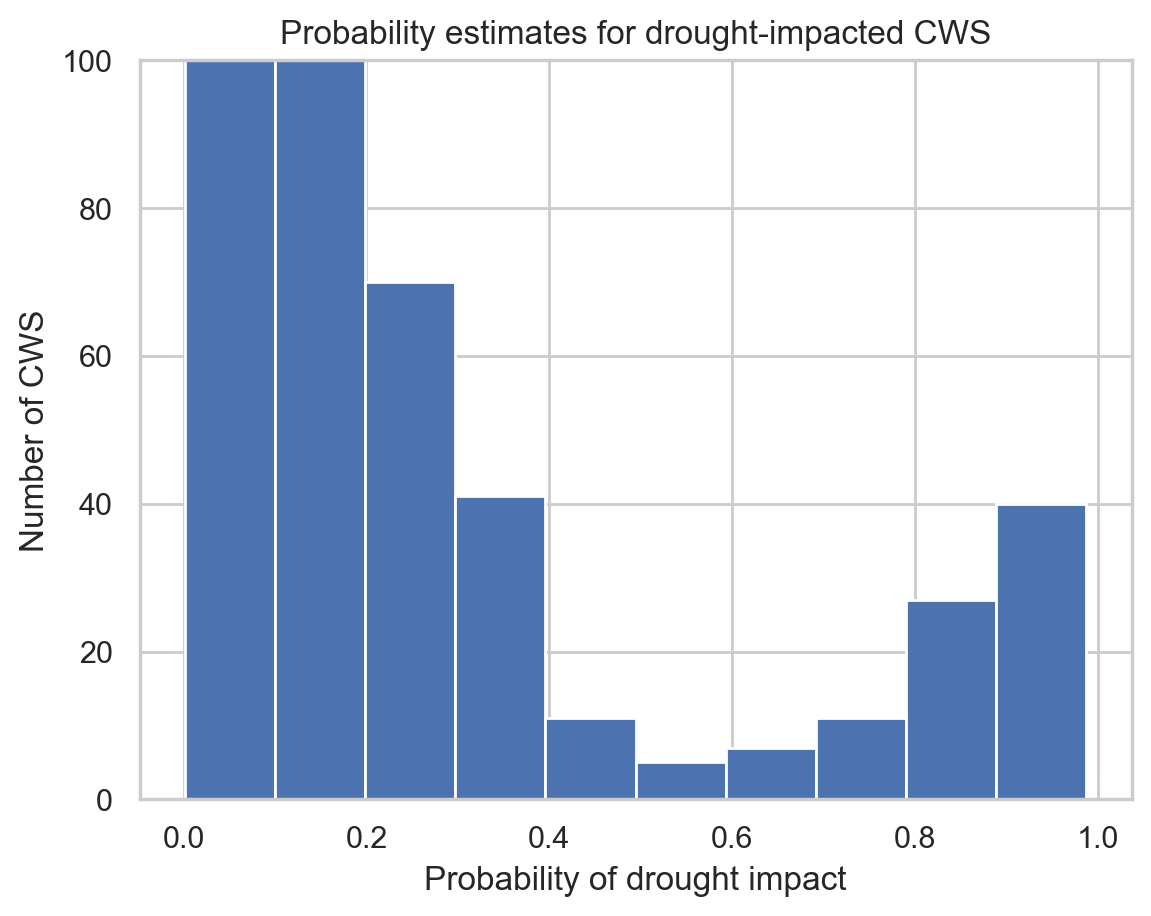

In [213]:
fig, ax = plt.subplots()
ax.hist(df_predictions_2023['Expected'])
ax.set_xlabel('Probability of drought impact')
ax.set_ylabel('Number of CWS')
ax.set_title('Probability estimates for drought-impacted CWS')
ax.set_ylim([0,100])
#fig.savefig('probability_drought_zoom.png', dpi=300, transparent=True, bbox_inches='tight')

### Why were these flagged?

There are many ways to interpret the results of a machine learning algorithm. The book [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/), written by Christoph Molnar, provides many suggestions. One suggestion is called a counterfactual example (see Section 9.3). To generate a counterfactual, we ask the question: Given that the model's output for input $x$ is $y$, what would be the output if input is changed to $x'$ ([Mothilal et al. 2021](https://arxiv.org/abs/2011.04917))? To answer this question, we can perturb the values of a feature for any given example and use the model to predict an outcome for this new example. We can then examine the features of this so-called counterfactual example to give us insight into what it takes to predict a different outcome. 

Answer these questions, which perturb features individually:  
* Would the prediction change if last year's outcome was different?
* Would the prediction change if the system didn't get curtailed?
* Would the prediction change if any of the risk indicator scores were different (`Score_SCM`, `Score_SCV`, and `Score_CriticallyOverdraftedGroundwaterBasin`)?
* Would the prediction change if any of the DSCI went down one severity level – in particular, if there was more rain during the wet season?

We also can perburb features in combination. For six features, where five have a binary outcome (`Outcome`, `Curtailment`, `Score_SCM`, `Score_SCV`, and `Score_CriticallyOverdraftedGroundwaterBasin`) and one feature (`DSCI Wet Season Average`) that steps through eight values (50, 100, 150, 200, 250, 300, 350, 400), the total number of combinations equals $2^5 x 8$, or 256. Note that we do not study DSCI values above 400, since there zero examples in the training set with a DSCI value greater than 400.

In [214]:
def generate_synthetic_data_for_all_failing_CWS(df_predictions, temporary_features, feature_name_to_change, new_feature_value, threshold=0.5):
    """
    Generates counterfactuals for a given feature.
    
    This function changes the value of a single feature for all failing CWS.
    To change multiple values of multiple features for a single CWS, use generate_synthetic_data_for_one_CWS().

    Parameters
    ----------
    df_predictions : pandas.DataFrame
        Dataframe containing the predictions and all the features.
    df_X_test_plus_temporary_features : pandas.DataFrame
        Dataframe containing the test set plus temporary features.
    temporary_features : list
        List of temporary features.
    feature_name_to_change : str
        The name of the feature to change.
    new_feature_value : int
        The new value of the feature.
    CWSIDs : list or str
        The CWSIDs, or singluar CWSID, on which to apply the counterfactual.
    threshold : float, default=0.5
        The threshold to use for identifying failing CWSs.
    
    Returns
    -------
    df_X_test_modified : pandas.DataFrame
        Dataframe containing the modified test set.
    
    Examples
    --------
    >>> df_X_test_modified = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions, $
    temporary_features=temporary_features, feature_name_to_change='Outcome', new_feature_value=0)
    """

    # Identify the failing CWSIDs by applying a threshold on the predicted probabilities
    failing_CWSIDs = df_predictions[df_predictions['Expected'] >= threshold]['CWSID'].to_list()

    # Copy the dataframe to preserve the original
    df_X_test_modified = df_X_test_plus_temporary_features.copy()

    # Identify singular feature and change to new value for all selected CWSIDs
    df_X_test_modified.loc[df_X_test_modified['CWSID'].isin(failing_CWSIDs), feature_name_to_change] = new_feature_value

    # Drop temporary features
    df_X_test_modified = df_X_test_modified.drop(columns=temporary_features).reset_index(drop=True)

    return df_X_test_modified

#### Would the prediction change if last year's outcome was different?

Yes, this shrinks the list of drought-impacted CWS to just one. The model is heavily reliant on the previous year's outcome to predict the current year's outcome. This is because only 46 CWS, which represents 1.6% of all CWS and 34.1% of all drought-experienced CWS, experienced drought in only one year. The other 2820 CWS had the same outcome in both years -- in other words, these CWS were either safe both years or drought-impacted both years.

In [215]:
df_X_test_modified_outcome = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='Outcome', new_feature_value=0)

In [216]:
y_pred_probability_outcome = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_outcome, clf=clf)

In [217]:
df_predictions_changed_outcome = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_outcome, y_pred_probability=y_pred_probability_outcome, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [218]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_outcome[df_predictions_changed_outcome['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_outcome[df_predictions_changed_outcome['Expected'] >= 0.2])))

The model flagged 4 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 139 CWS in 2023.


#### Would the prediction change if the system didn't get curtailed?

In [219]:
df_X_test_modified_curtailment = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='Curtailment', new_feature_value=0)
y_pred_probability_curtailment = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_curtailment, clf=clf)
df_predictions_changed_curtailment = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_curtailment, y_pred_probability=y_pred_probability_curtailment, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [220]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_curtailment[df_predictions_changed_curtailment['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_curtailment[df_predictions_changed_curtailment['Expected'] >= 0.2])))

The model flagged 79 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 206 CWS in 2023.


#### Would the prediction change if any of the risk indicator scores were different (`Score_SCM`, `Score_SCV`, and `Score_CriticallyOverdraftedGroundwaterBasin`)?

##### `Score_SCV`

In [221]:
df_X_test_modified_SCV = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='Score_SCV', new_feature_value=0)
y_pred_probability_SCV = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_SCV, clf=clf)
df_predictions_changed_SCV = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_SCV, y_pred_probability=y_pred_probability_SCV, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [222]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_SCV[df_predictions_changed_SCV['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_SCV[df_predictions_changed_SCV['Expected'] >= 0.2])))

The model flagged 87 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 210 CWS in 2023.


##### `Score_SCM`

In [223]:
df_X_test_modified_SCM = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='Score_SCM', new_feature_value=0)
y_pred_probability_SCM = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_SCM, clf=clf)
df_predictions_changed_SCM = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_SCM, y_pred_probability=y_pred_probability_SCM, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [224]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_SCM[df_predictions_changed_SCM['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_SCM[df_predictions_changed_SCM['Expected'] >= 0.2])))

The model flagged 88 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 210 CWS in 2023.


##### `Score_CriticallyOverdraftedGroundwaterBasin`

In [225]:
df_X_test_modified_overdraft = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='Score_CriticallyOverdraftedGroundwaterBasin', new_feature_value=0)
y_pred_probability_overdraft = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_overdraft, clf=clf)
df_predictions_changed_overdraft = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_overdraft, y_pred_probability=y_pred_probability_overdraft, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [226]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_overdraft[df_predictions_changed_overdraft['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_overdraft[df_predictions_changed_overdraft['Expected'] >= 0.2])))

The model flagged 89 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 210 CWS in 2023.


#### Would the prediction change if any of the DSCI went down one severity level – in particular, if there was more rain during the wet season?

Experiment by setting DSCI to 125, which represents the first quartile in the range (0 represents the lowest severity, and 500 the highest). 


From experiments, we see that the probability of risk for any given CWS goes down as the DSCI decreases from roughly 400. But the probability also goes down when the DSCI values increase above 400. The latter shows incorrect behavior -- but the model has zero examples of DSCI values greater than 400 (i.e. `X_train[X_train['DSCI Wet Season Average'] > 400]` will yeild an empty dataframe), and some of those are associated with safe water systems, so it makes sense that the model doesn't know how to deal with DSCI values above roughly 400.

In [227]:
df_X_test_modified_DSCI = generate_synthetic_data_for_all_failing_CWS(df_predictions=df_predictions_2023, temporary_features=temporary_features, feature_name_to_change='DSCI Wet Season Average', new_feature_value=125)
y_pred_probability_DSCI = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test_modified_DSCI, clf=clf)
df_predictions_changed_DSCI = append_features_and_names_to_predictions(df_X_test=df_X_test_modified_DSCI, y_pred_probability=y_pred_probability_DSCI, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])

In [228]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_changed_DSCI[df_predictions_changed_DSCI['Expected'] >= 0.5])))
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_changed_DSCI[df_predictions_changed_DSCI['Expected'] >= 0.2])))

The model flagged 33 CWS in 2023 (assuming a threshold of 50%).
If the threshold is 20%, the model flagged 201 CWS in 2023.


#### What are all the possible counterfactual examples for an at-risk CWS?

We want to know what it would take for any given CWS to go from at-risk to safe. To answer this question, we can select an individual CWS and perturb their features in combination. We can then look at which set of features, and their associated values, resulted in an at-risk outcome, and which resulted in a safe outcome.

In [229]:
def generate_all_counterfactuals_for_one_CWS(df_X_test_plus_temporary_features, DSCI_steps, Score_SCV_steps, Score_SCM_steps, Score_CriticallyOverdraftedGroundwaterBasin_steps, Outcome_steps, Curtailment_steps, Water_sources_steps, single_CWSID):
    """
    Generates all counterfactuals for a single CWS.

    Parameters
    ----------
    df_X_test_plus_temporary_features : pandas.DataFrame
        Dataframe containing the test set plus temporary features.
    DSCI_steps: list
        List of values to change for the feature DSCI Wet Season Average.
    Score_SCV_steps: list
        List of values to change for the feature Score_SCV.
    Score_SCM_steps: list
        List of values to change for the feature Score_SCM.
    Score_CriticallyOverdraftedGroundwaterBasin_steps: list
        List of values to change for the feature Score_CriticallyOverdraftedGroundwaterBasin.
    Outcome_steps: list
        List of values to change for the feature Outcome.
    Curtailment_steps: list
        List of values to change for the feature Curtailment.
    Water_Sources_steps: list
        List of values to change for the feature Total Number of Water Sources.
    single_CWSID : str
        The singluar CWSID on which to apply the counterfactual.
    
    Returns
    -------
    df_all_counterfactuals : pandas.DataFrame
        Dataframe containing all the counterfactuals for a given CWSID.
    
    Examples
    --------
    >>> df_all_counterfactuals = generate_all_counterfactuals_for_one_CWS(df_X_test_plus_temporary_features=df_X_test_plus_temporary_features, $
    DSCI_steps=DSCI_steps, Score_SCV_steps=Score_SCV_steps, Score_SCM_steps=Score_SCM_steps, $
    Score_CriticallyOverdraftedGroundwaterBasin_steps=Score_CriticallyOverdraftedGroundwaterBasin_steps, Outcome_steps=Outcome_steps, $
    Curtailment_steps=Curtailment_steps, Water_sources_steps=Water_sources_steps, single_CWSID='CA3301512')

    """
    # Check to see if any of the lists are empty
    if not DSCI_steps or not Score_SCV_steps or not Score_SCM_steps or not Score_CriticallyOverdraftedGroundwaterBasin_steps or not Outcome_steps or not Curtailment_steps or not Water_sources_steps:
        raise ValueError('At least one list must be non-empty.')

    # Create a list to hold all the counterfactuals
    list_all_counterfactuals = []

    # Generate the Cartesian product of the input iterables
    matrix = list(itertools.product(DSCI_steps, Score_SCV_steps, Score_SCM_steps,
                                    Score_CriticallyOverdraftedGroundwaterBasin_steps,
                                    Outcome_steps, Curtailment_steps, Water_sources_steps))
    
    # Convert the list of tuples to a pandas DataFrame
    df_replacement = pd.DataFrame(matrix, columns=['DSCI Wet Season Average', 'Score_SCV', 'Score_SCM',
                                   'Score_CriticallyOverdraftedGroundwaterBasin',
                                   'Outcome', 'Curtailment', 'Total Number of Water Sources'])

    
    for i in range(len(df_replacement)):
        # Create a dictionary of new values for the counterfactual example
        df_replacement_dict = df_replacement.loc[i].to_dict()
        
        # Identify the index of the CWSID
        index_single_CWSID = df_X_test_plus_temporary_features[df_X_test_plus_temporary_features['CWSID'] == single_CWSID].index[0]

        # Modify the values of the features
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'DSCI Wet Season Average'] = df_replacement_dict['DSCI Wet Season Average']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Score_SCV'] = df_replacement_dict['Score_SCV']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Score_SCM'] = df_replacement_dict['Score_SCM']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Score_CriticallyOverdraftedGroundwaterBasin'] = df_replacement_dict['Score_CriticallyOverdraftedGroundwaterBasin']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Outcome'] = df_replacement_dict['Outcome']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Curtailment'] = df_replacement_dict['Curtailment']
        df_X_test_plus_temporary_features.loc[index_single_CWSID, 'Total Number of Water Sources'] = df_replacement_dict['Total Number of Water Sources']
        
        # Drop temporary features
        df_X_test = df_X_test_plus_temporary_features.drop(columns=temporary_features).reset_index(drop=True)
        
        # Predict the probability
        y_pred_probability_tmp = generate_predictions(numeric_features=numeric_features, categorical_features=categorical_features, df_X_test=df_X_test, clf=clf)
        
        # Append the features and names to the predictions
        df_predictions_tmp = append_features_and_names_to_predictions(df_X_test=df_X_test, y_pred_probability=y_pred_probability_tmp, CWS_names=df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']])
        
        # Generate one counterfactual
        df_one_counterfactual = df_predictions_tmp[df_predictions_tmp['CWSID'] == single_CWSID]
        
        # Append the counterfactual to the list
        list_all_counterfactuals.append(df_one_counterfactual)

    # Concatenate all the counterfactuals
    df_all_counterfactuals = pd.concat(list_all_counterfactuals).sort_values(by=['Expected'], ascending=True).reset_index(drop=True)

    return df_all_counterfactuals

In [230]:
DSCI_steps = [50, 100, 150, 200, 250, 300, 350, 400]
Score_SCV_steps = [0, 1]
Score_SCM_steps = [0, 1]
Score_CriticallyOverdraftedGroundwaterBasin_steps = [0, 1]
Outcome_steps = [0, 1]
Curtailment_steps = [0, 1]
Water_sources_steps = [1, 2]

In [231]:
df_all_counterfactuals = generate_all_counterfactuals_for_one_CWS(df_X_test_plus_temporary_features=df_X_test_plus_temporary_features, 
                                                                  DSCI_steps=DSCI_steps, Score_SCV_steps=Score_SCV_steps, Score_SCM_steps=Score_SCM_steps,
                                                                  Score_CriticallyOverdraftedGroundwaterBasin_steps=Score_CriticallyOverdraftedGroundwaterBasin_steps, 
                                                                  Outcome_steps=Outcome_steps, Curtailment_steps=Curtailment_steps, Water_sources_steps=Water_sources_steps, 
                                                                  single_CWSID='CA3301512')

In [232]:
df_all_counterfactuals[500:512]

,CWSID,Not Expected,Expected,RegulatingAgency,WaterSystemName,Water Year,HUC8,ServiceConnections,Population,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome,PWPhysicalAddressLat,PWPhysicalAddressLong
500,CA3301512,0.000012,0.999988,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,350.0,71.646503,2.0,1.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
501,CA3301512,0.000011,0.999989,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,250.0,71.646503,2.0,1.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
502,CA3301512,0.000006,0.999994,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,250.0,71.646503,1.0,0.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
503,CA3301512,0.000006,0.999994,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,300.0,71.646503,1.0,0.0,1.0,1,0.0,0.0,0,3,1,33.5972,-116.449735
504,CA3301512,0.000005,0.999995,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,300.0,71.646503,2.0,0.0,1.0,1,0.0,0.0,0,3,1,33.5972,-116.449735
505,CA3301512,0.000005,0.999995,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,350.0,71.646503,1.0,0.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
506,CA3301512,0.000005,0.999995,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,350.0,71.646503,2.0,0.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
507,CA3301512,0.000005,0.999995,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,300.0,71.646503,1.0,1.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
508,CA3301512,0.000004,0.999996,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,250.0,71.646503,2.0,0.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735
509,CA3301512,0.000004,0.999996,LPA63 - RIVERSIDE COUNTY,PINYON PINES COUNTY WATER DIST,2022,18100201,82.0,160,322.437273,300.0,71.646503,2.0,1.0,1.0,1,0.0,0.0,1,3,1,33.5972,-116.449735


### Compare to 2022 outcomes

In [233]:
print('The model flagged {} CWS in the 2022 validation set (30% of the data).'.format(len(df_predictions_2022[df_predictions_2022['Expected'] >= 0.5])))
print('There were {} drought-impacted CWS in 2022.'.format(len(df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)])))

The model flagged 39 CWS in the 2022 validation set (30% of the data).
There were 122 drought-impacted CWS in 2022.


How many of the 2022 drought-impacted CWS were selected again in 2023?

In [234]:
list_cws_2022 = df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)]['CWSID'].to_list()
list_cws_2023 = df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]['CWSID'].to_list()

In [235]:
print('Of the {} CWS the model flagged in 2023, {} were also drought-impacted in 2022.'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]), 
                                                                                       len(list(set(list_cws_2022).intersection(list_cws_2023)))))

Of the 90 CWS the model flagged in 2023, 86 were also drought-impacted in 2022.


Here is the CWS flagged in 2023 but not in 2022:

In [236]:
set(list_cws_2023) - set(list_cws_2022)

{'CA1010051', 'CA1210022', 'CA2000729', 'CA2010017'}

Look at all the flagged CWS:

In [237]:
df_X_test_plus_temporary_features[df_X_test_plus_temporary_features['CWSID'] == 'CA1010051']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome
282,CA1010051,2022,18040001,251.0,772,36.990894,-119.710647,437.079091,404.207308,32.871783,1.0,0.0,0.0,0,0.0,0.0,1,2,0


In [238]:
df_X_test_plus_temporary_features[df_X_test_plus_temporary_features['CWSID'] == 'CA1210022']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome
346,CA1210022,2022,18010107,656.0,803,40.028593,-124.065326,288.556364,286.422692,2.133671,19.0,0.0,0.0,0,0.0,0.0,0,3,0


In [239]:
df_X_test_plus_temporary_features[df_X_test_plus_temporary_features['CWSID'] == 'CA2000729']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome
919,CA2000729,2022,18040001,41.0,135,36.961336,-120.060718,437.079091,404.207308,32.871783,1.0,0.0,0.0,0,0.0,0.0,1,2,0


In [240]:
df_X_test_plus_temporary_features[df_X_test_plus_temporary_features['CWSID'] == 'CA2010017']

,CWSID,Water Year,HUC8,ServiceConnections,Population,PWPhysicalAddressLat,PWPhysicalAddressLong,DSCI Dry Season Average,DSCI Wet Season Average,DSCI Dry Wet Delta,Total Number of Water Sources,Score_SCV,Score_SCM,Score_CriticallyOverdraftedGroundwaterBasin,Intertie,Wholesalers,Curtailment,HUC_Categories,Outcome
945,CA2010017,2022,18040001,505.0,2640,36.992005,-119.858377,437.079091,404.207308,32.871783,2.0,0.0,0.0,0,0.0,0.0,1,2,0


Where are the CWS that were drought-impacted in 2022?

In [241]:
df_2022_droughtCWS = df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)]

In [242]:
df_2023_droughtCWS = df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]

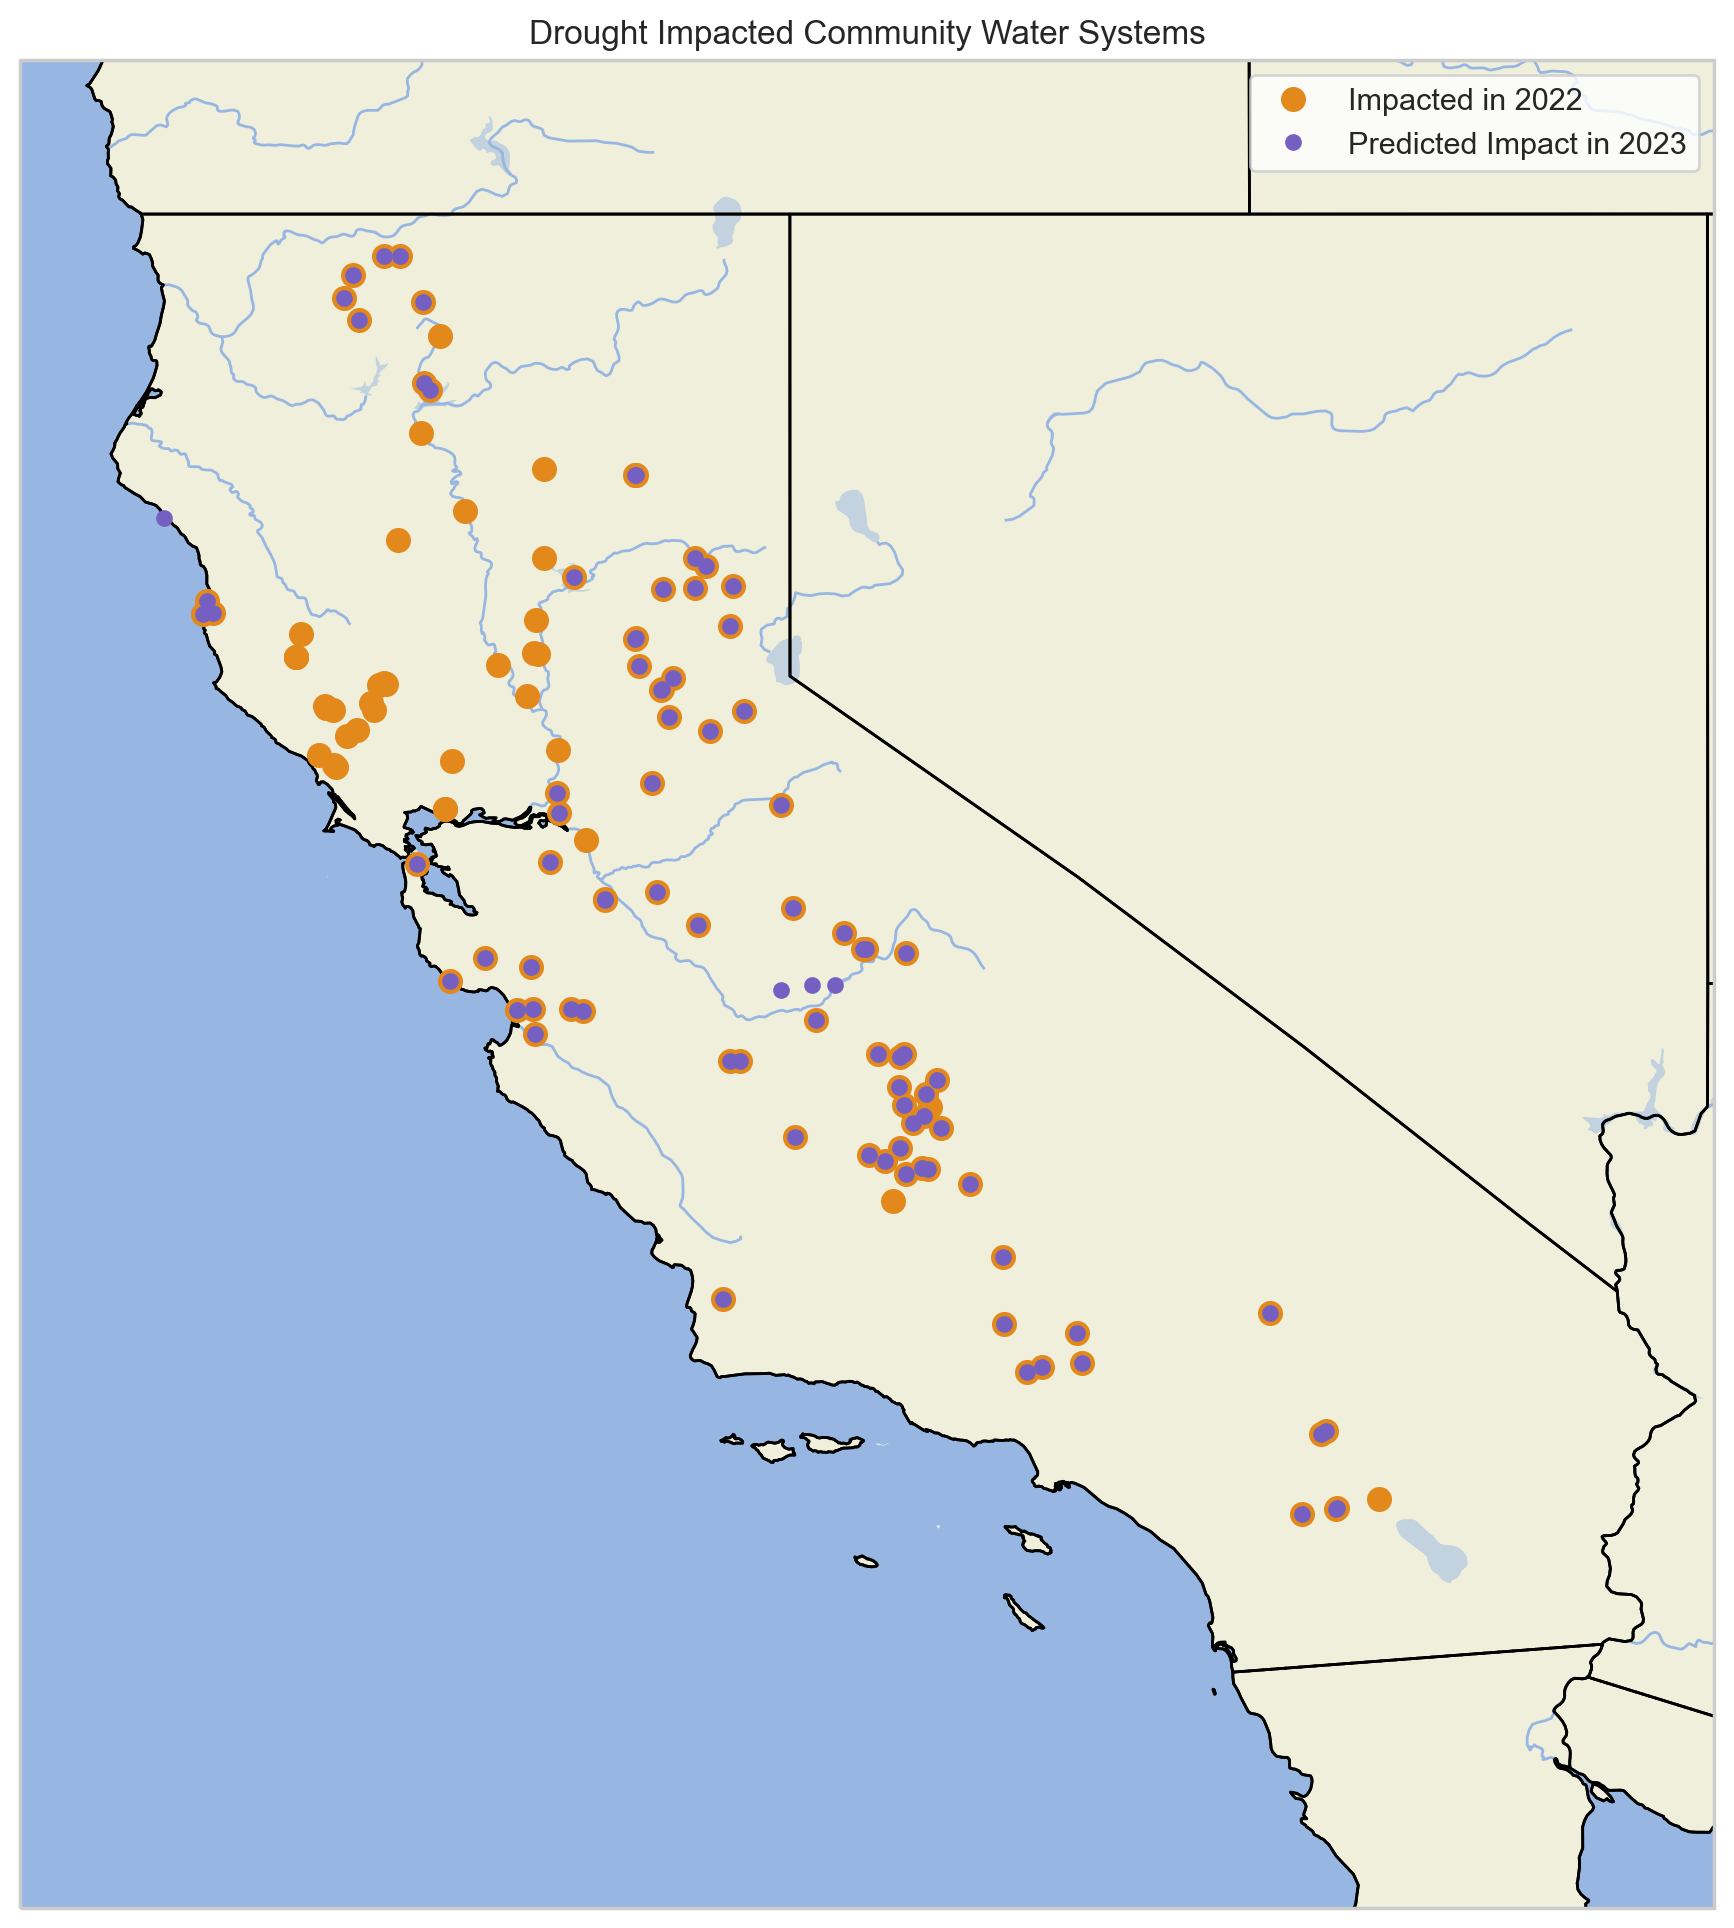

In [243]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -114, 31, 43], crs=ccrs.PlateCarree())

odi_mustard = "#E3881B"
odi_purple = "#7560C1"

ax.plot(df_2022_droughtCWS['PWPhysicalAddressLong'], df_2022_droughtCWS['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_mustard, markersize=8, alpha=1.0, transform=ccrs.PlateCarree(), label='Impacted in 2022')
ax.plot(df_2023_droughtCWS['PWPhysicalAddressLong'], df_2023_droughtCWS['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_purple, markersize=5, alpha=1.0, transform=ccrs.PlateCarree(), label='Predicted Impact in 2023')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)
ax.legend()
ax.set_title('Drought Impacted Community Water Systems')
plt.show()

#fig.savefig('locations.png', dpi=300, transparent=True, bbox_inches='tight')